In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


## **I. Analyse et nettoyage des données : Usines**

In [ ]:
factories_path = "/content/drive/MyDrive/Dataset/Factories/"

factories = ["Cement_1", "Cement_2",
             "Forge_1", "Forge_2",
             "Metal_1", "Metal_2", "Metal_3",
             "Paper",
             "Steel_1", "Steel_2"]

all_data = pd.DataFrame()

In [ ]:
import os

In [ ]:
for f in factories:
    df = pd.read_csv(os.path.join(factories_path, f + ".csv"))
    df.columns = ["dateTime", "kW"]
    df["factory"] = f
    all_data = pd.concat([all_data, df], ignore_index=True)

all_data["dateTime"] = pd.to_datetime(all_data["dateTime"])
all_data.head()

dateTime      kW   factory
0 2019-03-01 00:00:00  1164.8  Cement_1
1 2019-03-01 00:01:00  1142.4  Cement_1
2 2019-03-01 00:02:00  1164.8  Cement_1
3 2019-03-01 00:03:00  1142.4  Cement_1
4 2019-03-01 00:04:00  1164.8  Cement_1

In [ ]:
factory_lab = {
    'Steel_2': 'Acier 2',
    'Steel_1': 'Acier 1',
    'Paper': 'Papier',
    'Metal_3': 'Métal 3',
    'Metal_2': 'Métal 2',
    'Metal_1': 'Métal 1',
    'Forge_2': 'Forge 2',
    'Forge_1': 'Forge 1',
    'Cement_2': 'Ciment 2',
    'Cement_1': 'Ciment 1'
}

In [ ]:
import matplotlib.pyplot as plt

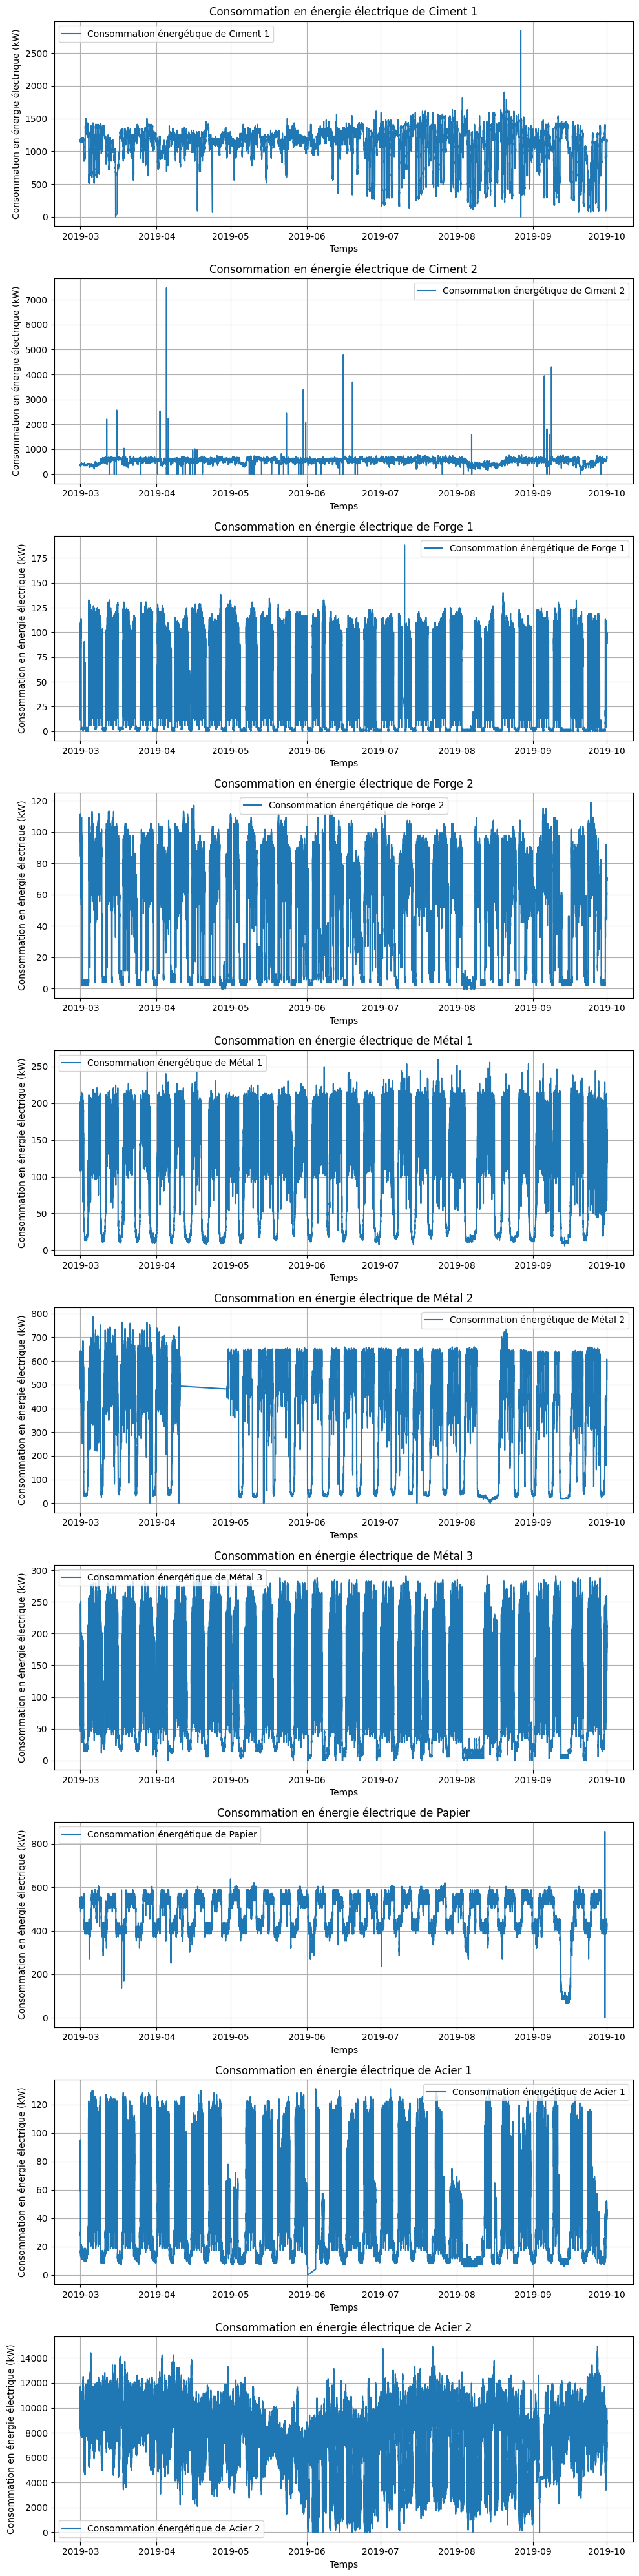

In [ ]:
num_factories = len(factories)

fig, axes = plt.subplots(num_factories, 1, figsize=(10, 4*num_factories))

for idx, factory in enumerate(factories):

    factory_data = pd.read_csv(os.path.join(factories_path, f"{factory}.csv"))
    factory_data['Time'] = pd.to_datetime(factory_data['Time'])

    ax = axes[idx]

    ax.plot(factory_data['Time'], factory_data['Power consumption'], label=f'Consommation énergétique de {factory_lab[factory]}')

    ax.set_xlabel('Temps')
    ax.set_ylabel('Consommation en énergie électrique (kW)')
    ax.set_title(f'Consommation en énergie électrique de {factory_lab[factory]}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def time_to_hours(t):
  return t.hour

all_data['hms'] = all_data['dateTime'].dt.time
all_data['hms_hours'] = all_data['hms'].apply(time_to_hours)
all_data['weekDay'] = all_data['dateTime'].dt.day_name()
all_data['Month'] = all_data['dateTime'].dt.month_name()
all_data.head()

dateTime      kW   factory       hms  hms_hours weekDay  Month
0 2019-03-01 00:00:00  1164.8  Cement_1  00:00:00          0  Friday  March
1 2019-03-01 00:01:00  1142.4  Cement_1  00:01:00          0  Friday  March
2 2019-03-01 00:02:00  1164.8  Cement_1  00:02:00          0  Friday  March
3 2019-03-01 00:03:00  1142.4  Cement_1  00:03:00          0  Friday  March
4 2019-03-01 00:04:00  1164.8  Cement_1  00:04:00          0  Friday  March

In [ ]:
plotDT = all_data.groupby(['factory', 'weekDay', 'hms_hours'])['kW'].mean().reset_index(name='mean_kW')

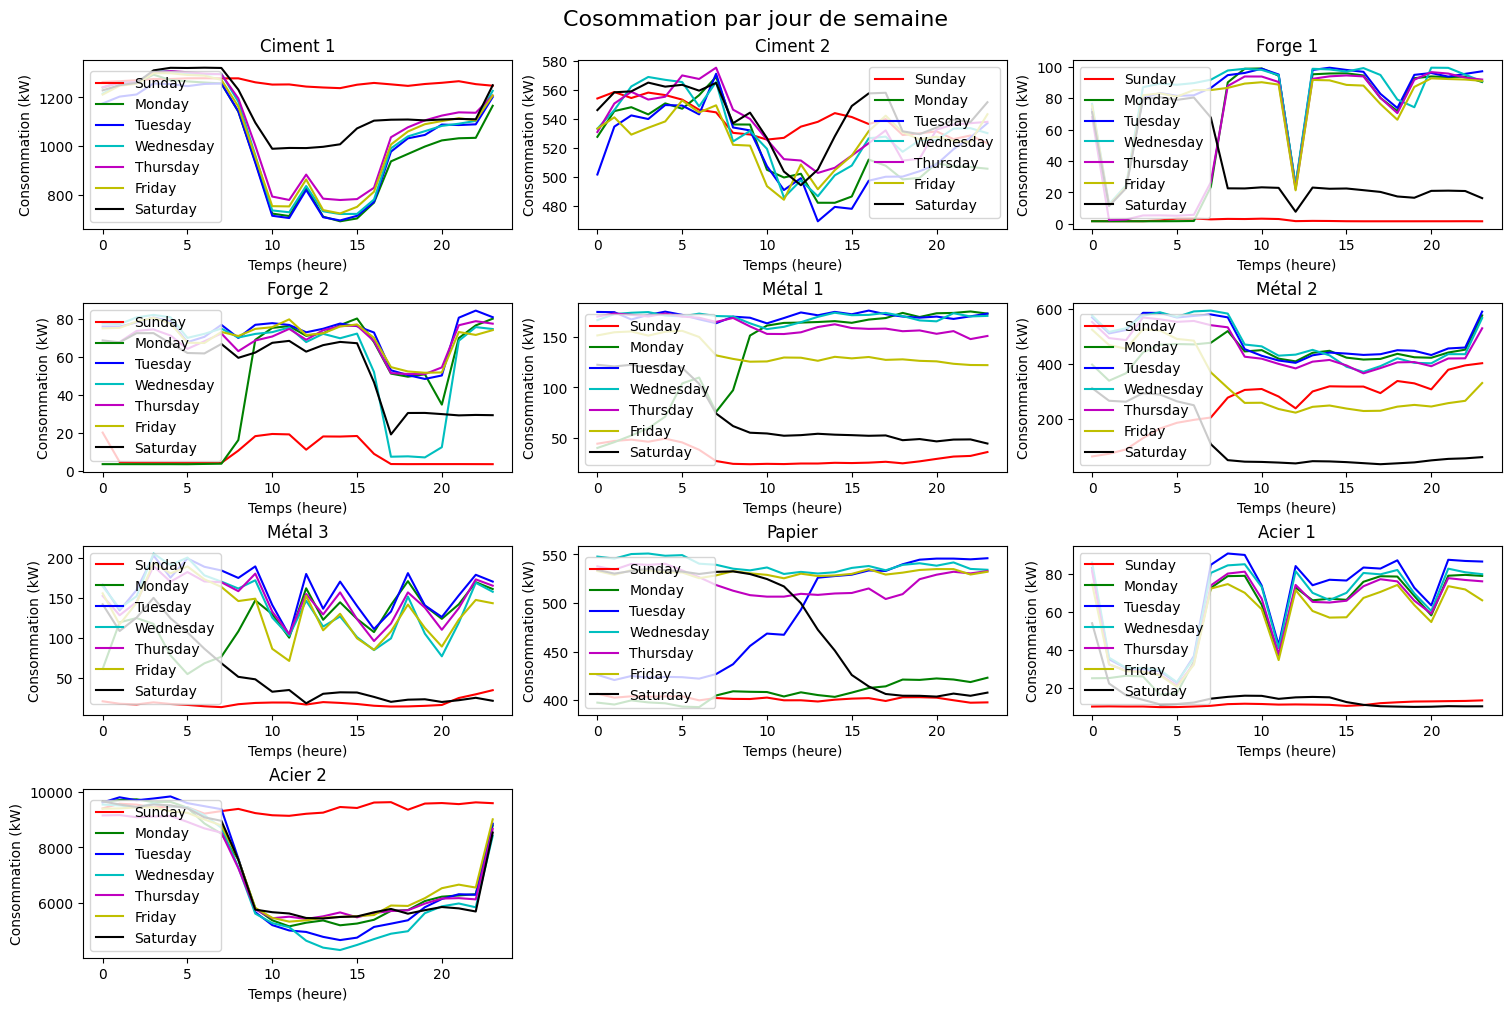

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), constrained_layout=True)
axs = axs.flatten()


for i, (factory, df) in enumerate(plotDT.groupby('factory')):
    ax = axs[i]
    for weekDay, color in zip(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                              ['r', 'g', 'b', 'c', 'm', 'y', 'k']):
        day_data = df[df['weekDay'] == weekDay]
        ax.plot(day_data['hms_hours'], day_data['mean_kW'], label=weekDay, color=color)
    ax.set_title(factory_lab[factory])
    ax.set_xlabel('Temps (heure)')
    ax.set_ylabel('Consommation (kW)')
    ax.legend()

# Remove any empty subplots
for i in range(len(plotDT['factory'].unique()), len(axs)):
    fig.delaxes(axs[i])

plt.suptitle('Cosommation par jour de semaine', fontsize=16)
plt.show()

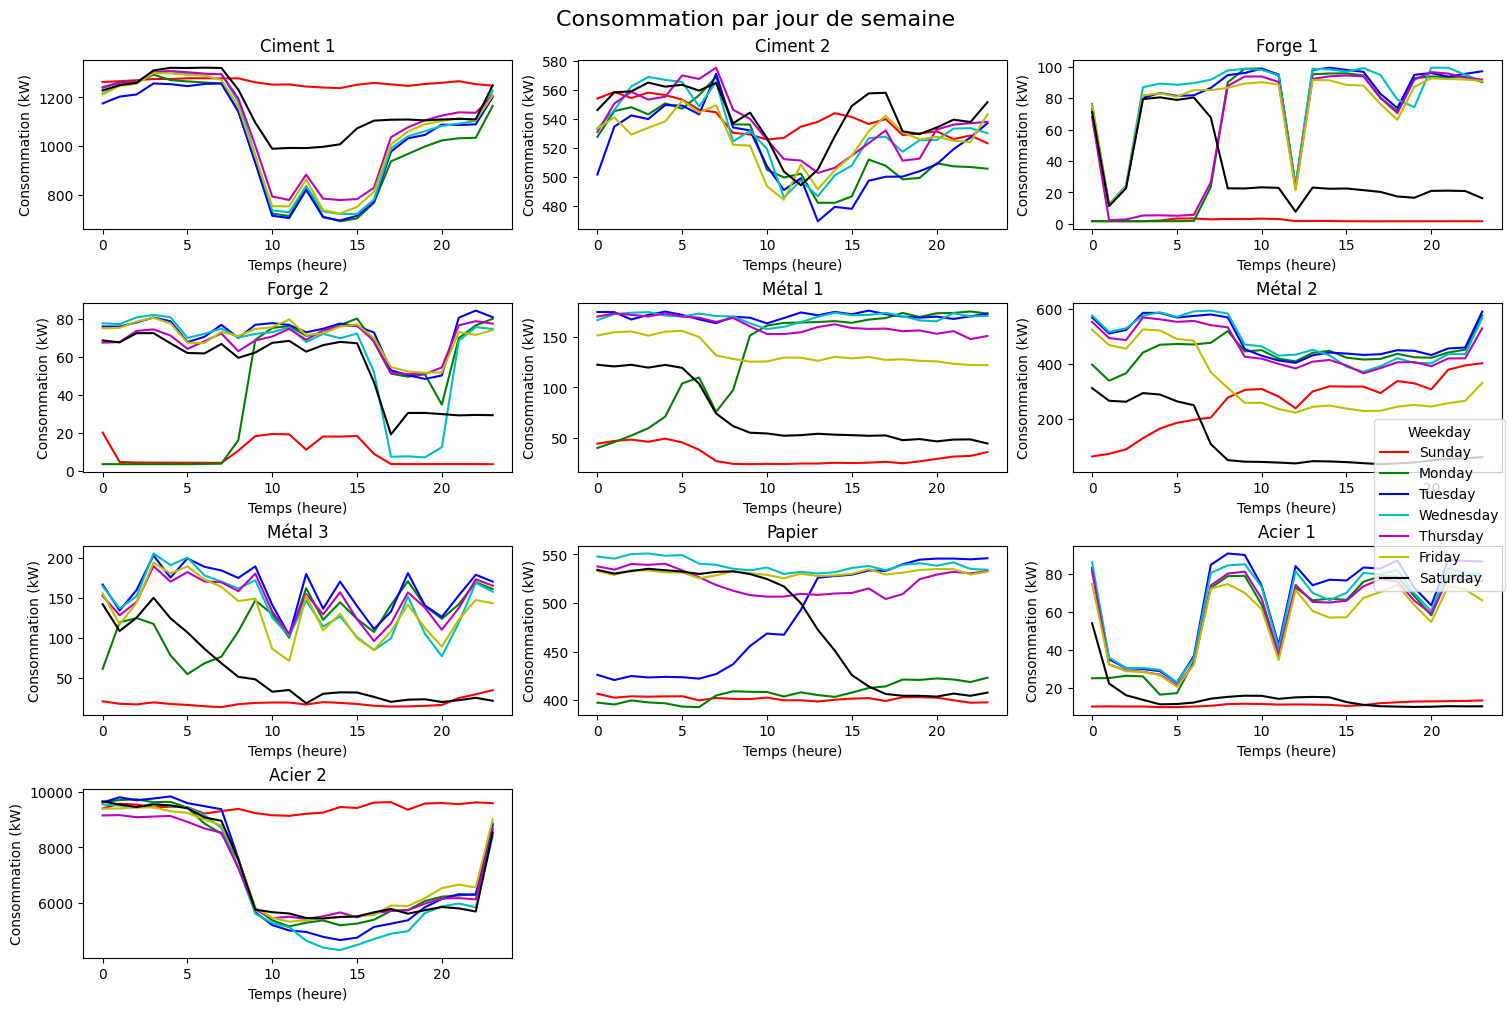

In [ ]:
# Create subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), constrained_layout=True)
axs = axs.flatten()

# Initialize lists for handles and labels
handles, labels = [], []

# Plot data for each factory
for i, (factory, df) in enumerate(plotDT.groupby('factory')):
    ax = axs[i]
    for weekDay, color in zip(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                              ['r', 'g', 'b', 'c', 'm', 'y', 'k']):
        day_data = df[df['weekDay'] == weekDay]
        line, = ax.plot(day_data['hms_hours'], day_data['mean_kW'], label=weekDay, color=color)
        if i == 0:  # Collect handles and labels once
            handles.append(line)
            labels.append(weekDay)
    ax.set_title(factory_lab[factory])
    ax.set_xlabel('Temps (heure)')
    ax.set_ylabel('Consommation (kW)')

# Remove any empty subplots
for i in range(len(plotDT['factory'].unique()), len(axs)):
    fig.delaxes(axs[i])

# Create a single legend for the entire figure
fig.legend(handles, labels, loc='center right', title='Weekday')

# Add a super title
plt.suptitle('Consommation par jour de semaine', fontsize=16)
plt.show()


# **1. Outliers**

In [ ]:
def calculate_cap(df):
    Q1 = df['kW'].quantile(0.25)
    Q3 = df['kW'].quantile(0.75)
    IQR = Q3 - Q1
    return Q3 + 1.5 * IQR

In [ ]:
cap = all_data.groupby('factory').apply(calculate_cap).reset_index()
cap.columns = ['factory', 'CAP']

In [ ]:
# Identify data points that exceed the threshold
outlier_counts = {}
outliers_data = {}
for factory in all_data['factory'].unique():
    threshold = cap.loc[cap['factory'] == factory, 'CAP'].values[0]
    outliers = all_data[(all_data['factory'] == factory) & (all_data['kW'] > threshold)]
    outliers_data[factory] = outliers
    outlier_counts[factory] = len(outliers)

In [ ]:
# Print the counts of outliers
for factory, count in outlier_counts.items():
    print(f"Factory: {factory}, Number of outliers: {count}")

Factory: Cement_1, Number of outliers: 4
Factory: Cement_2, Number of outliers: 38
Factory: Forge_1, Number of outliers: 0
Factory: Forge_2, Number of outliers: 0
Factory: Metal_1, Number of outliers: 0
Factory: Metal_2, Number of outliers: 0
Factory: Metal_3, Number of outliers: 0
Factory: Paper, Number of outliers: 1
Factory: Steel_1, Number of outliers: 0
Factory: Steel_2, Number of outliers: 0


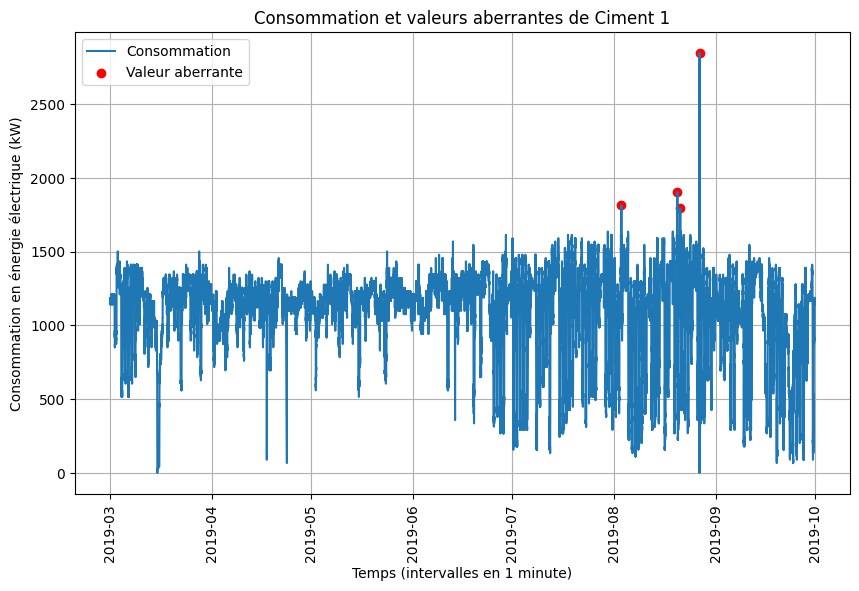

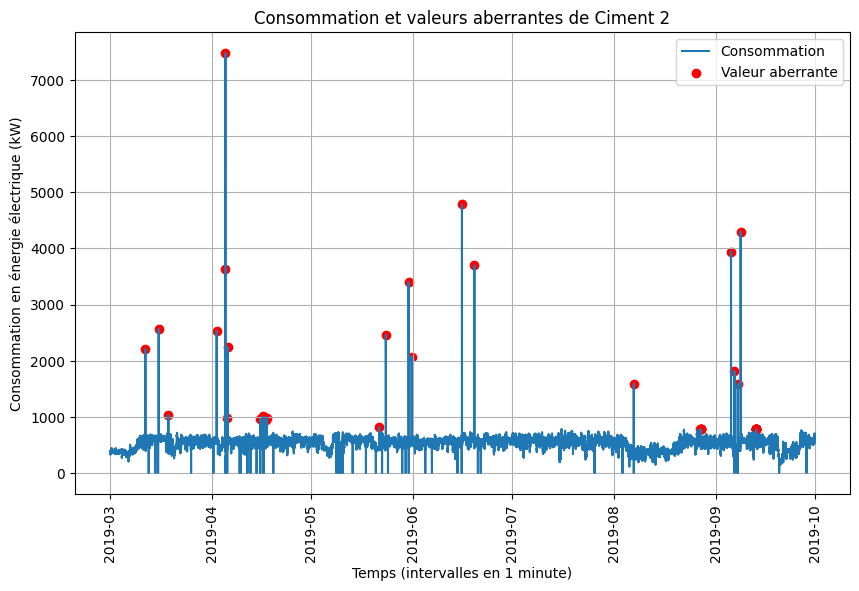

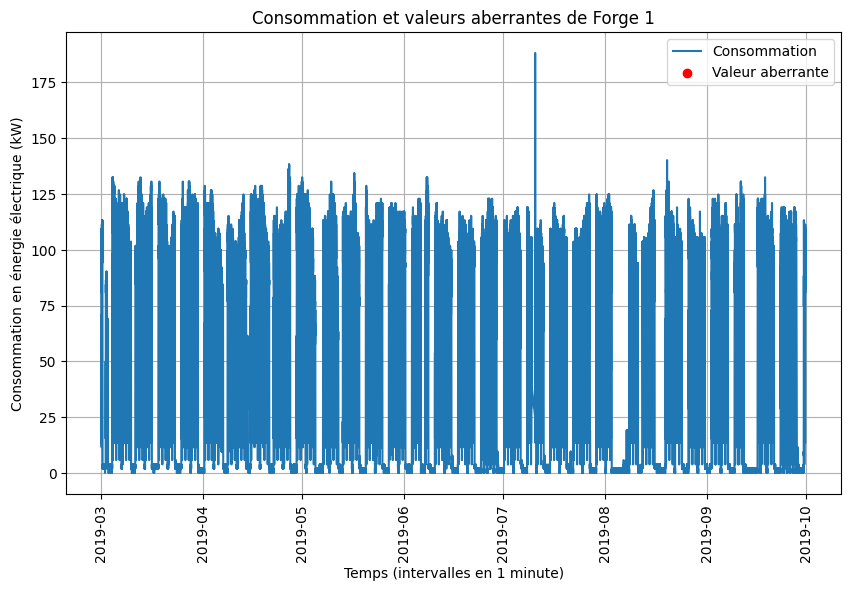

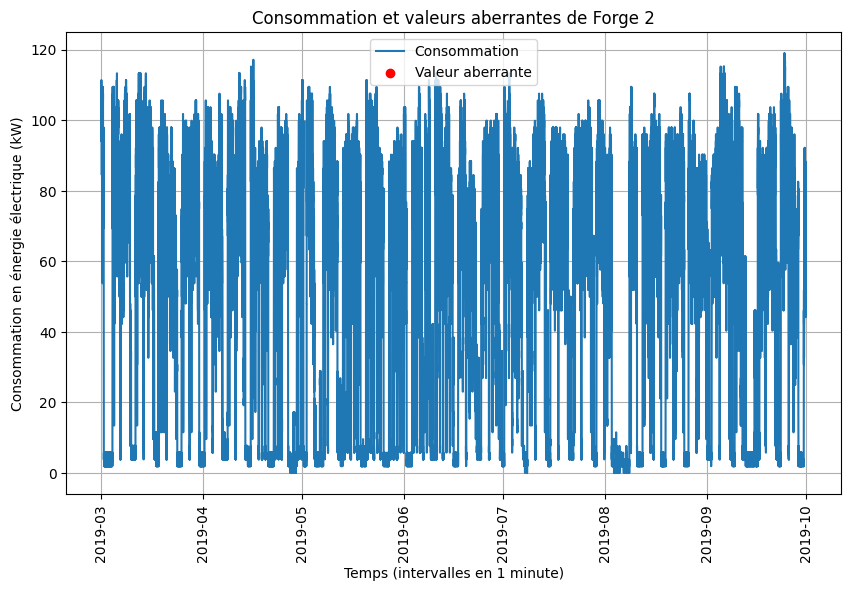

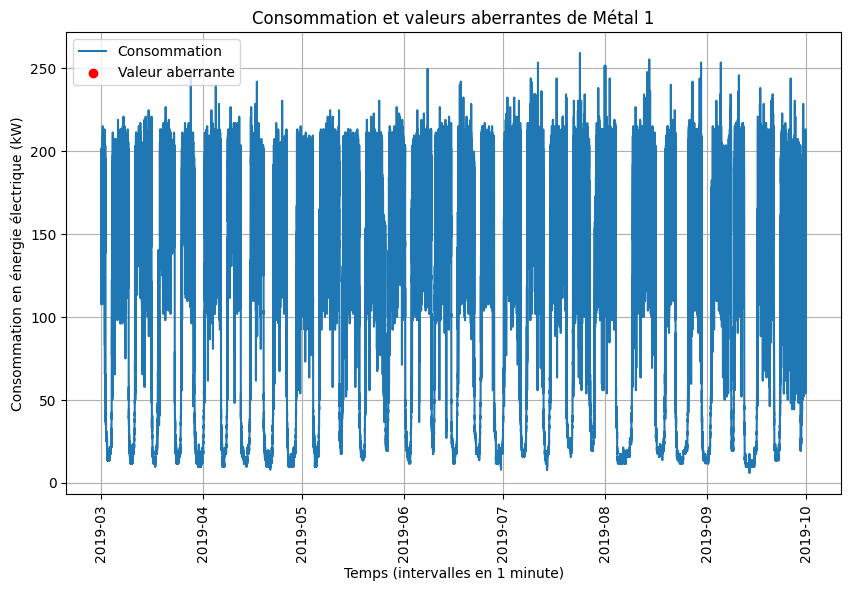

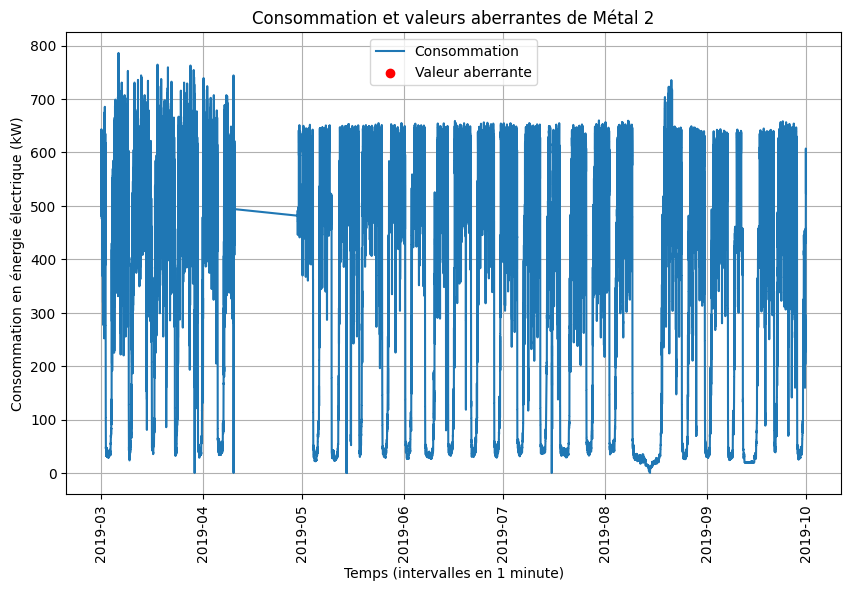

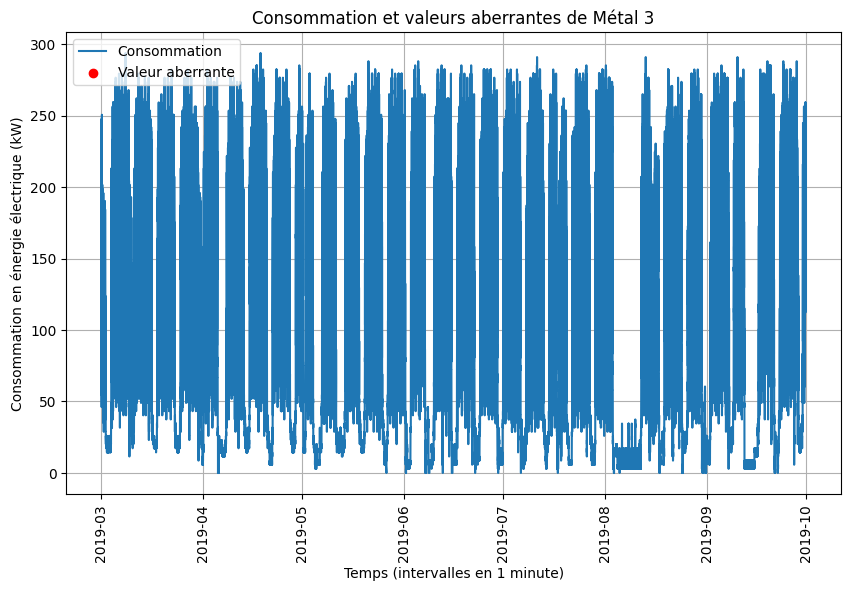

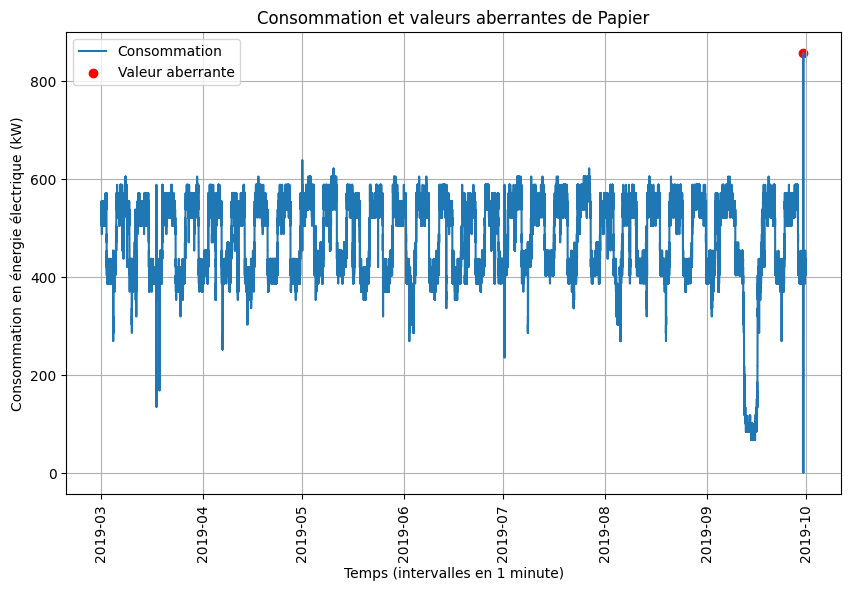

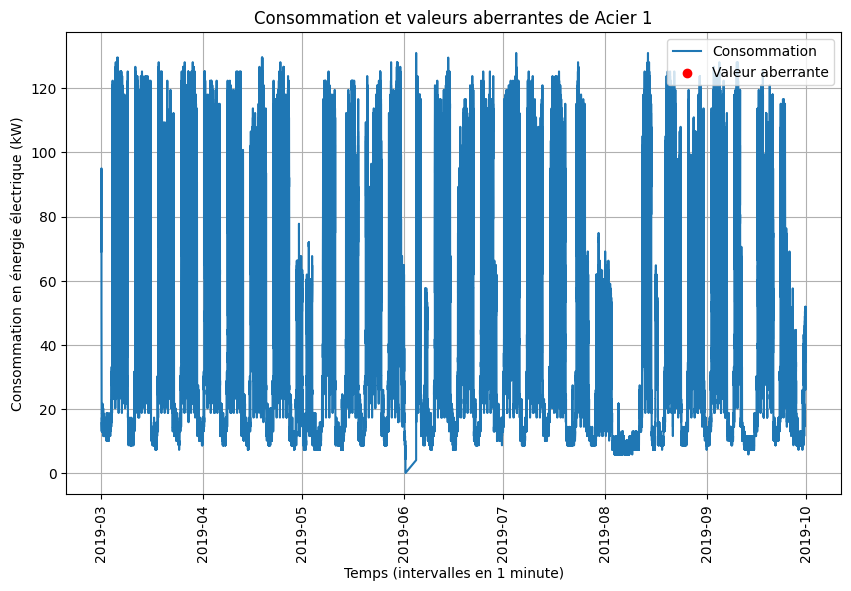

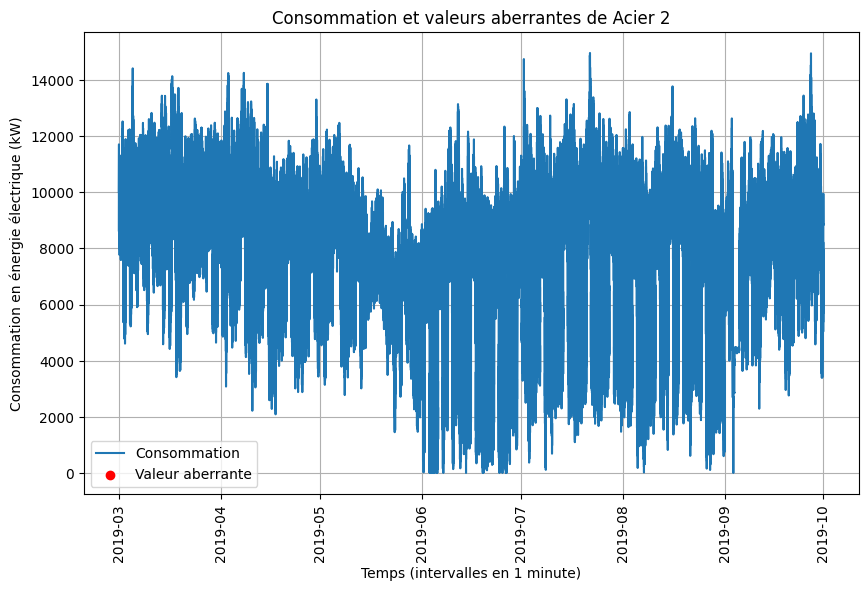

In [ ]:
# visualize the outliers for each factory
for factory, outliers in outliers_data.items():
    plt.figure(figsize=(10, 6))
    factory_data = all_data[all_data['factory'] == factory]
    plt.plot(factory_data['dateTime'], factory_data['kW'], label='Consommation')
    plt.scatter(outliers['dateTime'], outliers['kW'], color='red', label='Valeur aberrante')
    plt.xlabel('Temps (intervalles en 1 minute)')
    plt.ylabel('Consommation en énergie électrique (kW)')
    plt.title(f'Consommation et valeurs aberrantes de {factory_lab[factory]}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# Define a function to remove outliers
def remove_outliers(df):
    factory = df['factory'].iloc[0]
    threshold = cap.loc[cap['factory'] == factory, 'CAP'].values[0]
    return df[df['kW'] <= threshold]

In [ ]:
all_data_cleaned = all_data.groupby('factory').apply(remove_outliers).reset_index(drop=True)

In [ ]:
outlier_counts_after = all_data_cleaned.groupby('factory').apply(lambda df: df[(df['kW'] > df['kW'].quantile(0.75) + 1.5 * (df['kW'].quantile(0.75) - df['kW'].quantile(0.25)))].shape[0]).reset_index()
outlier_counts_after.columns = ['factory', 'outliers_after']

print("Number of outliers after removal:\n", outlier_counts_after)

print("Old Shape: ", all_data.shape)
print("New Shape: ", all_data_cleaned.shape)

Number of outliers after removal:
     factory  outliers_after
0  Cement_1               0
1  Cement_2               0
2   Forge_1               0
3   Forge_2               0
4   Metal_1               0
5   Metal_2               0
6   Metal_3               0
7     Paper               0
8   Steel_1               0
9   Steel_2               0
Old Shape:  (3041578, 7)
New Shape:  (3041535, 7)


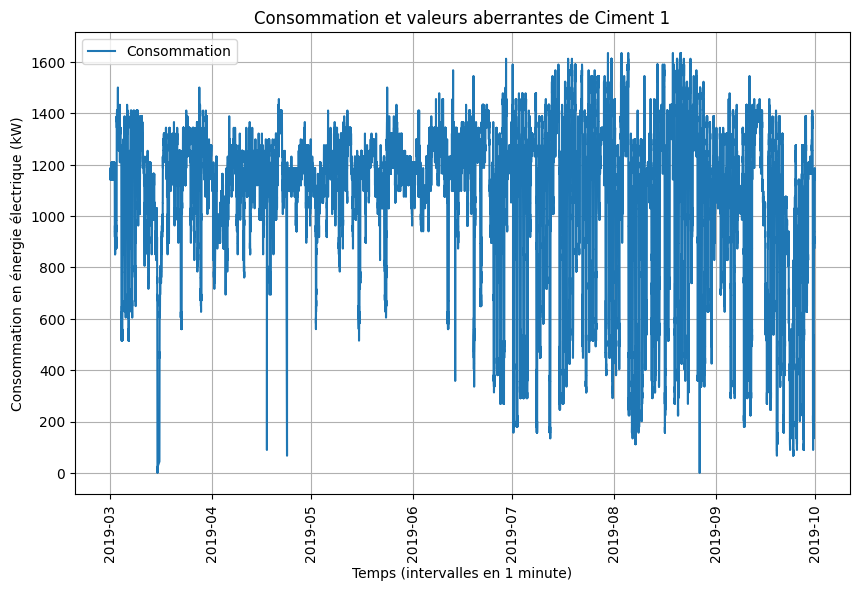

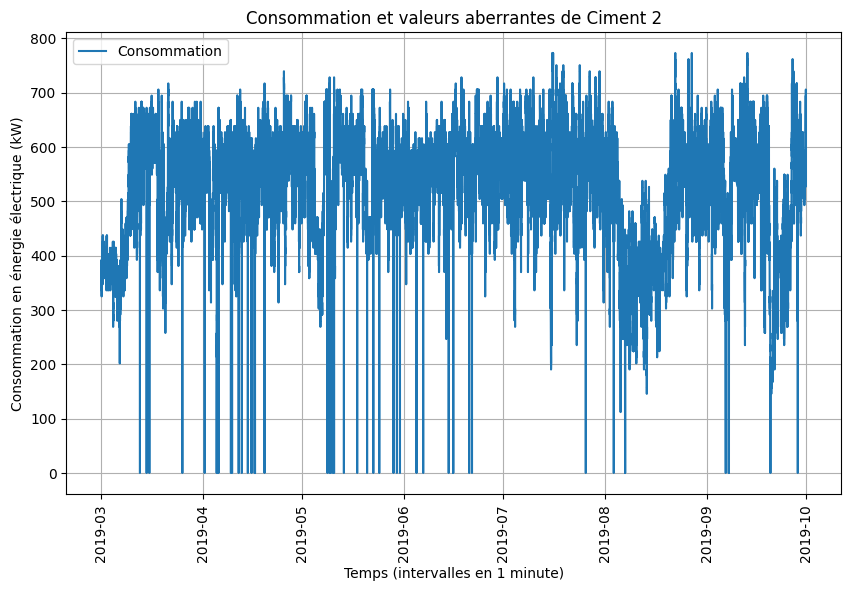

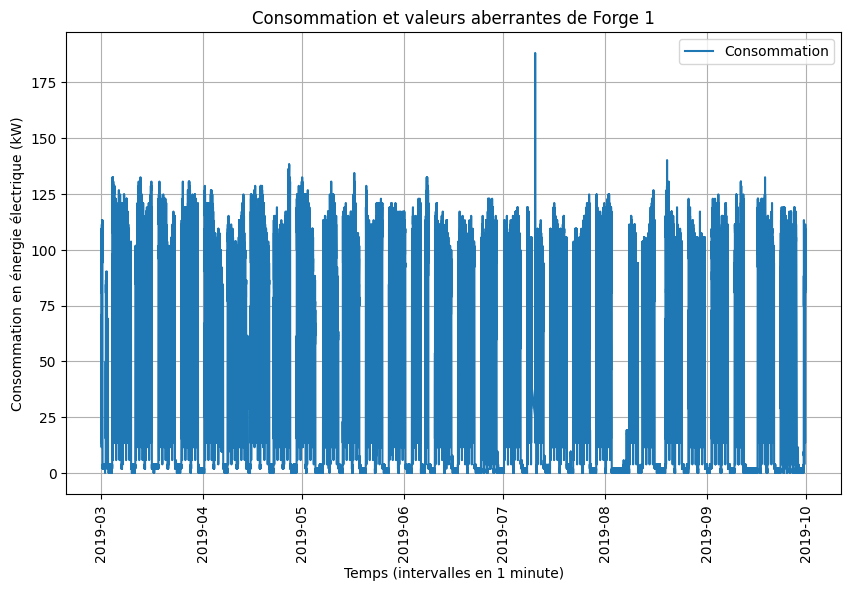

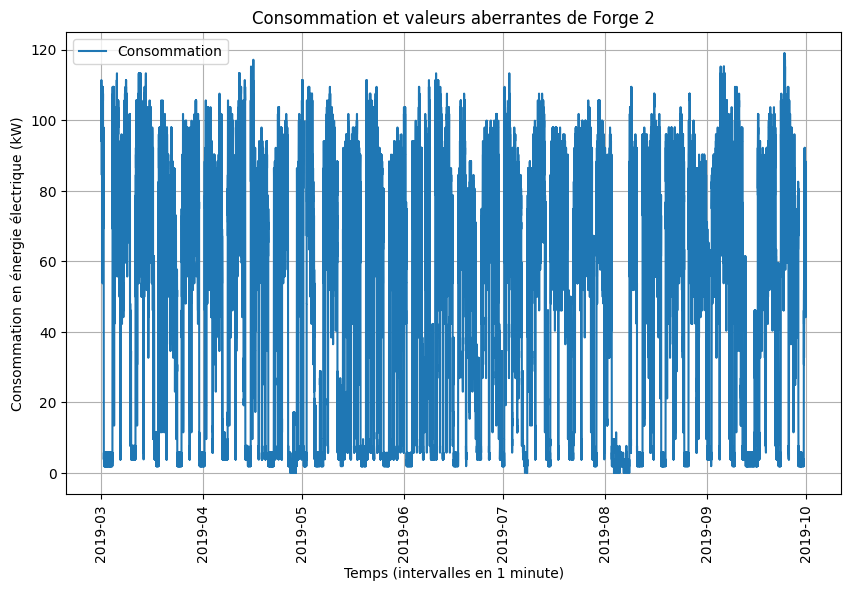

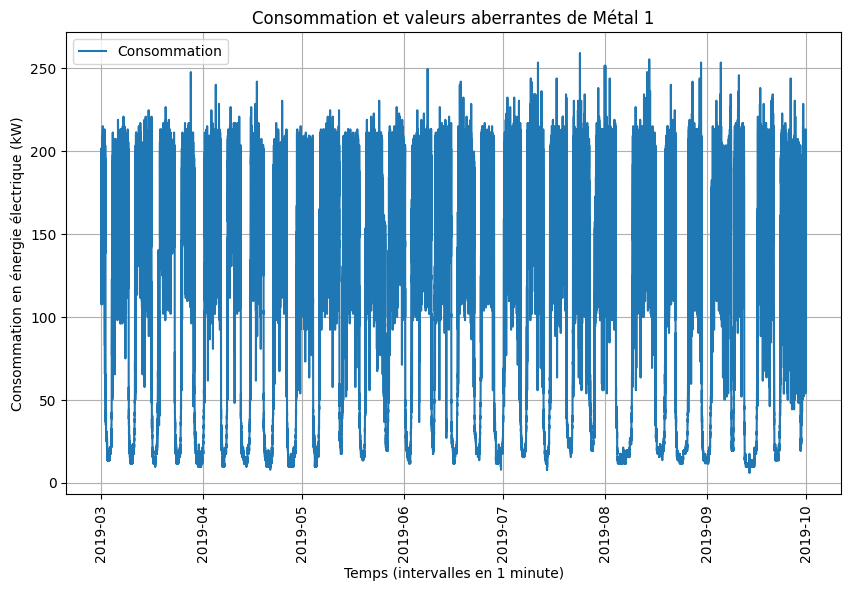

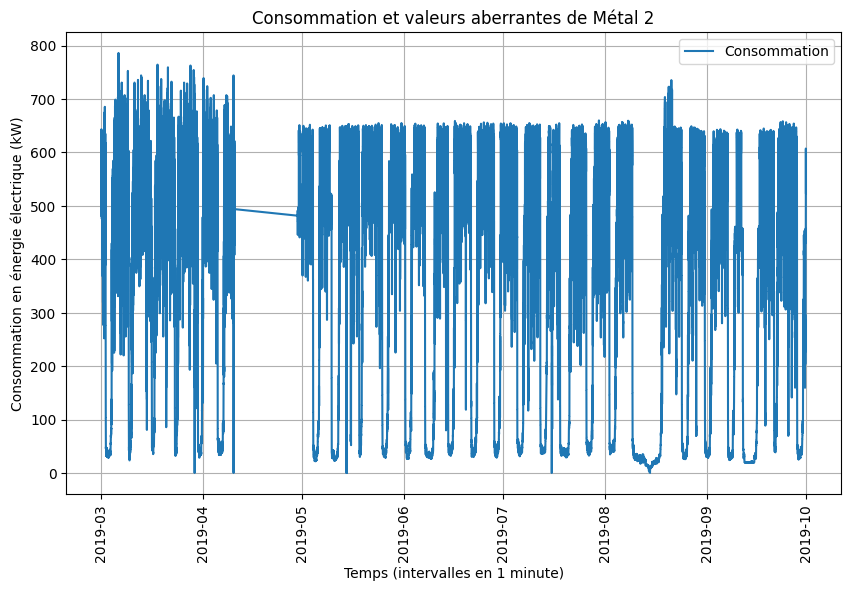

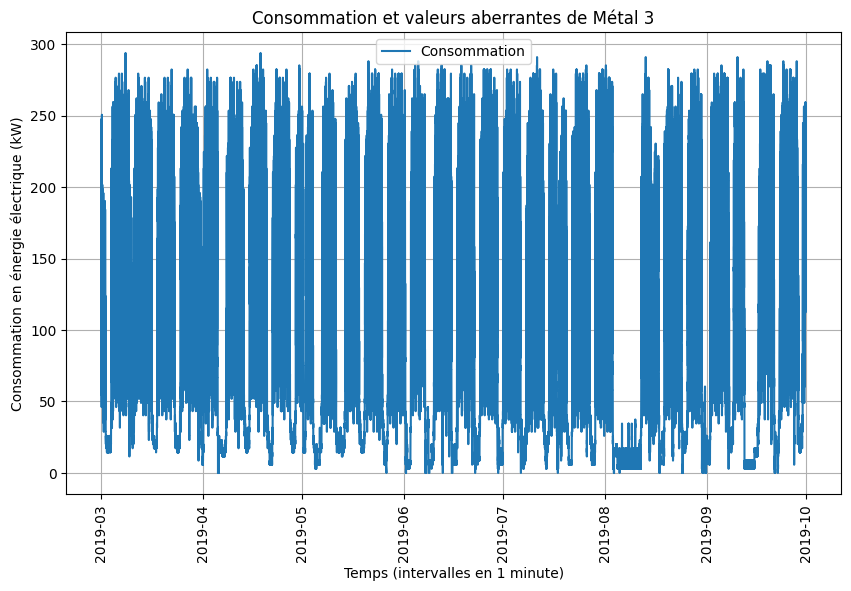

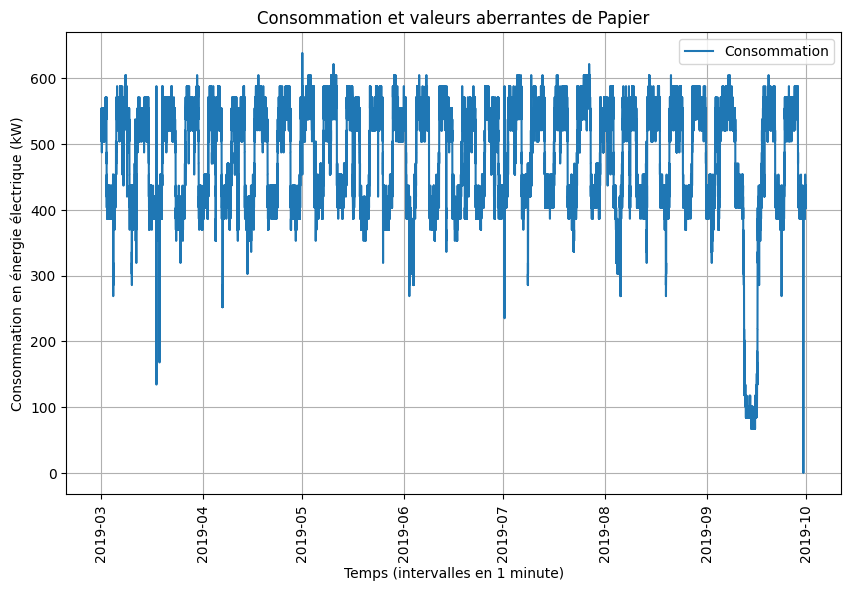

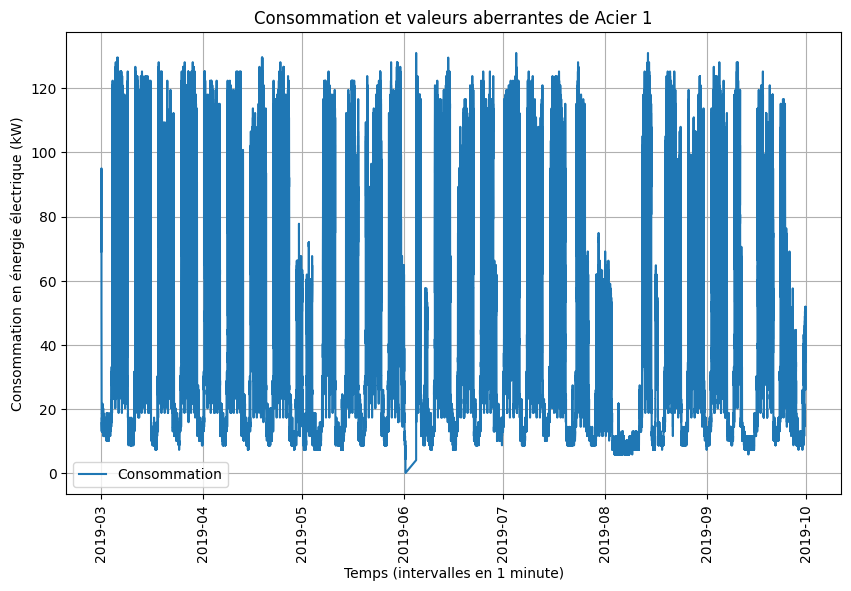

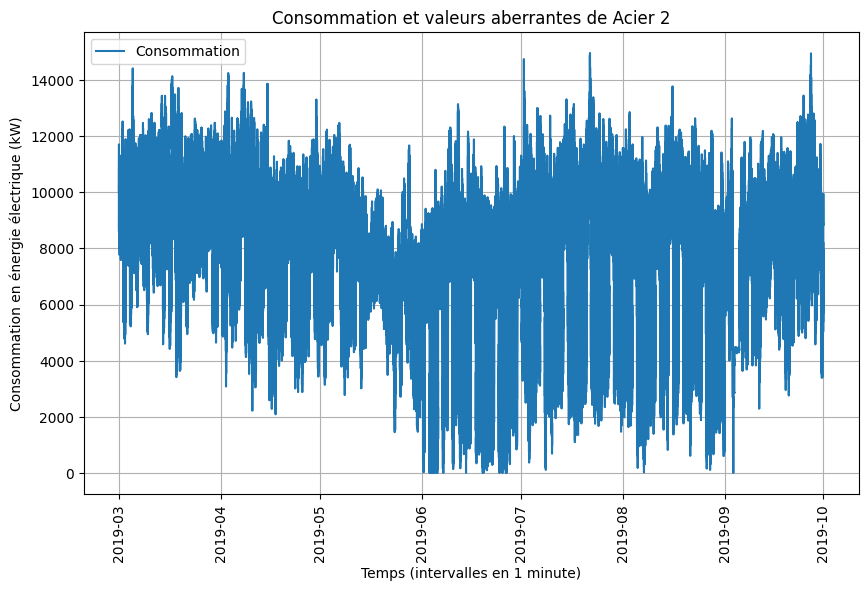

In [ ]:
for idx, factory in enumerate(factories):
    plt.figure(figsize=(10, 6))
    factory_data = all_data_cleaned[all_data_cleaned['factory'] == factory]
    plt.plot(factory_data['dateTime'], factory_data['kW'], label='Consommation')
    plt.xlabel('Temps (intervalles en 1 minute)')
    plt.ylabel('Consommation en énergie électrique (kW)')
    plt.title(f'Consommation et valeurs aberrantes de {factory_lab[factory]}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
plotDT = all_data_cleaned.groupby(['factory', 'weekDay', 'hms_hours'])['kW'].mean().reset_index(name='mean_kW')

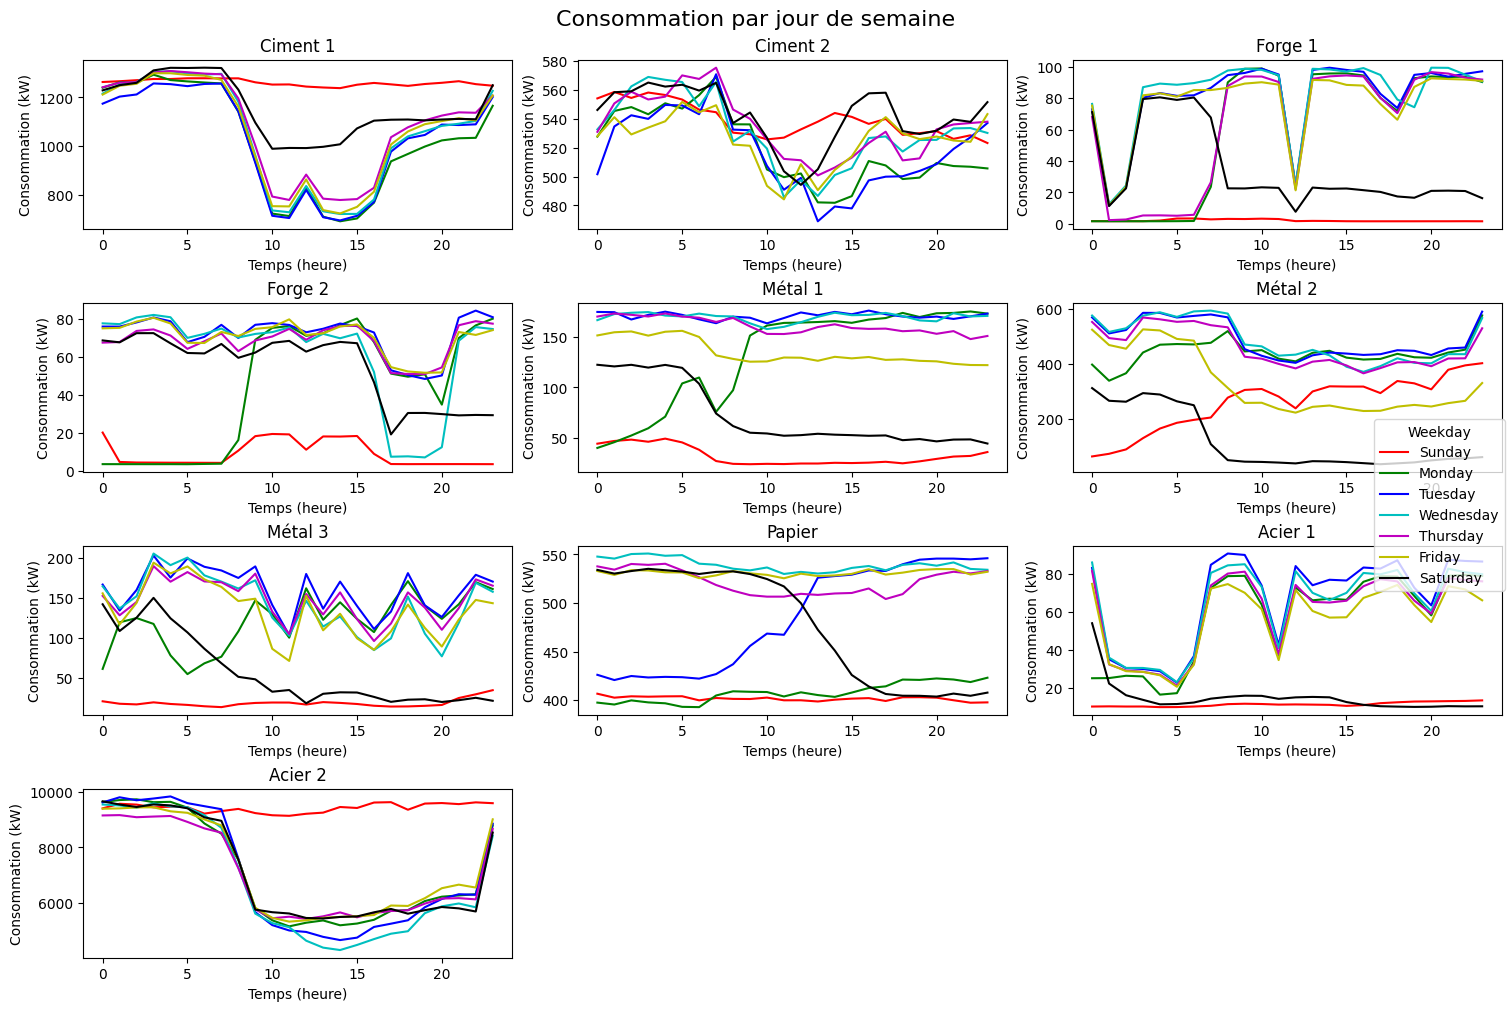

In [ ]:
# Create subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), constrained_layout=True)
axs = axs.flatten()

# Initialize lists for handles and labels
handles, labels = [], []

# Plot data for each factory
for i, (factory, df) in enumerate(plotDT.groupby('factory')):
    ax = axs[i]
    for weekDay, color in zip(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                              ['r', 'g', 'b', 'c', 'm', 'y', 'k']):
        day_data = df[df['weekDay'] == weekDay]
        line, = ax.plot(day_data['hms_hours'], day_data['mean_kW'], label=weekDay, color=color)
        if i == 0:  # Collect handles and labels once
            handles.append(line)
            labels.append(weekDay)
    ax.set_title(factory_lab[factory])
    ax.set_xlabel('Temps (heure)')
    ax.set_ylabel('Consommation (kW)')

# Remove any empty subplots
for i in range(len(plotDT['factory'].unique()), len(axs)):
    fig.delaxes(axs[i])

# Create a single legend for the entire figure
fig.legend(handles, labels, loc='center right', title='Weekday')

# Add a super title
plt.suptitle('Consommation par jour de semaine', fontsize=16)
plt.show()

# **2. Missing Data**

In [ ]:
missing_data_percentage = {}

In [ ]:
for factory in all_data['factory'].unique():
    factory_data = all_data[all_data['factory'] == factory]
    full_time_range = pd.date_range(start=factory_data['dateTime'].min(), end=factory_data['dateTime'].max(), freq='T')
    missing_minutes = full_time_range.difference(factory_data['dateTime']).shape[0]
    total_minutes = len(full_time_range)
    missing_percentage = (missing_minutes / total_minutes) * 100
    missing_data_percentage[factory] = missing_percentage

In [ ]:
missing_data_df = pd.DataFrame(list(missing_data_percentage.items()), columns=['Factory', 'Missing Data Percentage'])
print(missing_data_df)

    Factory  Missing Data Percentage
0  Cement_1                 0.395574
1  Cement_2                 0.222287
2   Forge_1                 0.488058
3   Forge_2                 0.042510
4   Metal_1                 0.001947
5   Metal_2                10.131750
6   Metal_3                 0.192757
7     Paper                 0.000649
8   Steel_1                 1.511877
9   Steel_2                 0.000000


In [ ]:
all_data['Date'] = all_data['dateTime'].dt.date

In [ ]:
pivot_data = all_data.pivot_table(index='Date', columns='factory', values='kW', aggfunc='size')

pivot_data_binary = pivot_data.notna().astype(int)

pivot_data_binary = pivot_data_binary.T

In [ ]:
import seaborn as sns

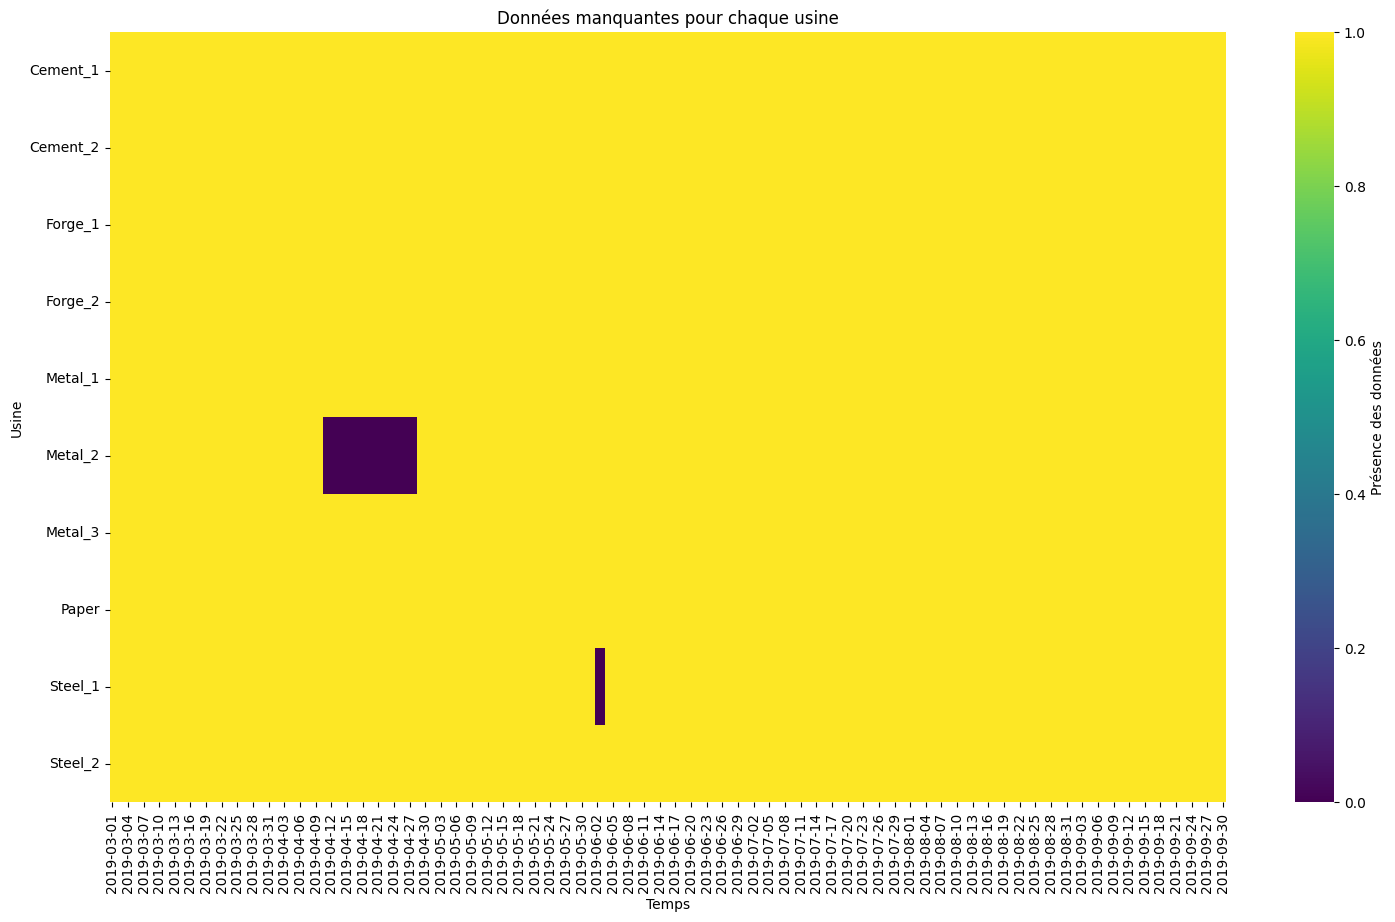

In [ ]:
plt.figure(figsize=(18, 10))
sns.heatmap(pivot_data_binary, cmap='viridis', cbar_kws={'label': 'Présence des données'})
plt.xlabel('Temps')
plt.ylabel('Usine')
plt.title('Données manquantes pour chaque usine')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Convert the 'Date' column to a datetime format if it is not already
all_data_cleaned['Date'] = pd.to_datetime(all_data['Date'])

# Extract the month from the 'Date' column and add it as a new column 'Month'
all_data_cleaned['Month'] = all_data_cleaned['Date'].dt.month

# Verify the updated DataFrame
all_data_cleaned.head()

dateTime      kW   factory       hms  hms_hours weekDay  Month  \
0 2019-03-01 00:00:00  1164.8  Cement_1  00:00:00          0  Friday      3   
1 2019-03-01 00:01:00  1142.4  Cement_1  00:01:00          0  Friday      3   
2 2019-03-01 00:02:00  1164.8  Cement_1  00:02:00          0  Friday      3   
3 2019-03-01 00:03:00  1142.4  Cement_1  00:03:00          0  Friday      3   
4 2019-03-01 00:04:00  1164.8  Cement_1  00:04:00          0  Friday      3   

        Date  
0 2019-03-01  
1 2019-03-01  
2 2019-03-01  
3 2019-03-01  
4 2019-03-01

In [ ]:
import numpy as np

processed_data = []

for factory in factories:
    factory_data = all_data_cleaned[all_data_cleaned['factory'] == factory].copy()
    factory_data.set_index('dateTime', inplace=True)
    full_time_index = pd.date_range(start=factory_data.index.min(), end=factory_data.index.max(), freq='T')
    factory_data = factory_data.reindex(full_time_index)

    factory_data['factory'] = factory
    factory_data['weekDay'] = factory_data.index.dayofweek
    factory_data['hms'] = factory_data.index.time
    factory_data['Date'] = factory_data.index.date
    factory_data['hms_hours'] = factory_data.index.hour
    factory_data['Month'] = factory_data.index.month

    missing_data_before = factory_data.isnull().mean() * 100
    print(f"Missing data percentage before imputation for {factory}:\n", missing_data_before)

    # Calculate the mean kW values for each combination of month, weekday, and hour
    pivot_table = factory_data.pivot_table(values='kW', index=['Month', 'weekDay'], columns='hms_hours', aggfunc='mean')

    def impute_kw(row):
        if np.isnan(row['kW']):
            return pivot_table.loc[(row['Month'], row['weekDay']), row['hms_hours']]
        else:
            return row['kW']

    factory_data['kW'] = factory_data.apply(impute_kw, axis=1)

    processed_data.append(factory_data)

    missing_data_after = factory_data.isnull().mean() * 100
    print(f"Missing data percentage after imputation for {factory}:\n", missing_data_after)


Missing data percentage before imputation for Cement_1:
 kW           0.396872
factory      0.000000
hms          0.000000
hms_hours    0.000000
weekDay      0.000000
Month        0.000000
Date         0.000000
dtype: float64
Missing data percentage after imputation for Cement_1:
 kW           0.0
factory      0.0
hms          0.0
hms_hours    0.0
weekDay      0.0
Month        0.0
Date         0.0
dtype: float64
Missing data percentage before imputation for Cement_2:
 kW           0.234618
factory      0.000000
hms          0.000000
hms_hours    0.000000
weekDay      0.000000
Month        0.000000
Date         0.000000
dtype: float64
Missing data percentage after imputation for Cement_2:
 kW           0.0
factory      0.0
hms          0.0
hms_hours    0.0
weekDay      0.0
Month        0.0
Date         0.0
dtype: float64
Missing data percentage before imputation for Forge_1:
 kW           0.488058
factory      0.000000
hms          0.000000
hms_hours    0.000000
weekDay      0.000000
Mo

In [ ]:
all_data_imputed = pd.concat(processed_data)

all_data_imputed.reset_index(inplace=True)
all_data_imputed.rename(columns={'index': 'dateTime'}, inplace=True)

all_data_imputed.head()

dateTime      kW   factory       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00  1164.8  Cement_1  00:00:00          0        4      3   
1 2019-03-01 00:01:00  1142.4  Cement_1  00:01:00          0        4      3   
2 2019-03-01 00:02:00  1164.8  Cement_1  00:02:00          0        4      3   
3 2019-03-01 00:03:00  1142.4  Cement_1  00:03:00          0        4      3   
4 2019-03-01 00:04:00  1164.8  Cement_1  00:04:00          0        4      3   

         Date  
0  2019-03-01  
1  2019-03-01  
2  2019-03-01  
3  2019-03-01  
4  2019-03-01

In [ ]:
all_data_imputed['weekDayName'] = all_data_imputed['dateTime'].dt.day_name()
all_data_imputed.head()

dateTime      kW   factory       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00  1164.8  Cement_1  00:00:00          0        4      3   
1 2019-03-01 00:01:00  1142.4  Cement_1  00:01:00          0        4      3   
2 2019-03-01 00:02:00  1164.8  Cement_1  00:02:00          0        4      3   
3 2019-03-01 00:03:00  1142.4  Cement_1  00:03:00          0        4      3   
4 2019-03-01 00:04:00  1164.8  Cement_1  00:04:00          0        4      3   

         Date weekDayName  
0  2019-03-01      Friday  
1  2019-03-01      Friday  
2  2019-03-01      Friday  
3  2019-03-01      Friday  
4  2019-03-01      Friday

# **II. La réponse à la demande**

In [ ]:
DR_info = pd.DataFrame({
    'factory': ["Metal_1", "Metal_2", "Metal_3", "Forge_1", "Forge_2", "Steel_1", "Steel_2", "Cement_1", "Cement_2", "Paper"],
    'cap': [8777.160, 24278.625, 10727.100, 4440.360, 9.360, 3924.540, 195414.970, 51198.000, 18998.700, 12509.700],
    'st': ["18:00", "16:00", "18:00", "18:00", "18:00", "18:00", "18:00", "18:00", "18:00", "18:00"],
    'et': ["19:00", "17:00", "19:00", "19:00", "19:00", "19:00", "19:00", "19:00", "19:00", "19:00"]
})

In [ ]:
DR_info['Duration'] = (pd.to_datetime(DR_info['et'], format='%H:%M') - pd.to_datetime(DR_info['st'], format='%H:%M')).dt.total_seconds() / 60

print(DR_info)

    factory         cap     st     et  Duration
0   Metal_1    8777.160  18:00  19:00      60.0
1   Metal_2   24278.625  16:00  17:00      60.0
2   Metal_3   10727.100  18:00  19:00      60.0
3   Forge_1    4440.360  18:00  19:00      60.0
4   Forge_2       9.360  18:00  19:00      60.0
5   Steel_1    3924.540  18:00  19:00      60.0
6   Steel_2  195414.970  18:00  19:00      60.0
7  Cement_1   51198.000  18:00  19:00      60.0
8  Cement_2   18998.700  18:00  19:00      60.0
9     Paper   12509.700  18:00  19:00      60.0


In [ ]:
from datetime import datetime
all_data_imputed_2 = all_data_imputed.copy()
event_day = datetime.strptime('2019-06-13', '%Y-%m-%d').date()

event_data = all_data_imputed_2[all_data_imputed_2['Date'] == event_day].copy()

event_data['CBL'] = event_data['kW']

print(event_data.head())

                  dateTime      kW   factory       hms  hms_hours  weekDay  \
149760 2019-06-13 00:00:00  1299.2  Cement_1  00:00:00          0        3   
149761 2019-06-13 00:01:00  1321.6  Cement_1  00:01:00          0        3   
149762 2019-06-13 00:02:00  1321.6  Cement_1  00:02:00          0        3   
149763 2019-06-13 00:03:00  1299.2  Cement_1  00:03:00          0        3   
149764 2019-06-13 00:04:00  1321.6  Cement_1  00:04:00          0        3   

        Month        Date weekDayName     CBL  
149760      6  2019-06-13    Thursday  1299.2  
149761      6  2019-06-13    Thursday  1321.6  
149762      6  2019-06-13    Thursday  1321.6  
149763      6  2019-06-13    Thursday  1299.2  
149764      6  2019-06-13    Thursday  1321.6  


In [ ]:
event_data['hms'] = pd.to_datetime(event_data['hms'], format='%H:%M:%S').dt.time

In [ ]:
for index, row in DR_info.iterrows():
    factory = row['factory']
    st = row['st']
    et = row['et']
    cap = row['cap']
    duration = row['Duration']

    # Convert start and end times to datetime.time
    start_time = datetime.strptime(st, '%H:%M').time()
    end_time = datetime.strptime(et, '%H:%M').time()

    mask = (event_data['factory'] == factory) & \
           (event_data['hms'] >= start_time) & \
           (event_data['hms'] < end_time)

    # Ensure that the mask is applied correctly
    event_data.loc[mask, 'CBL'] += cap / duration


In [ ]:
print(event_data[event_data['hms_hours'] == 18])

                   dateTime       kW   factory       hms  hms_hours  weekDay  \
150840  2019-06-13 18:00:00   380.80  Cement_1  18:00:00         18        3   
150841  2019-06-13 18:01:00   403.20  Cement_1  18:01:00         18        3   
150842  2019-06-13 18:02:00   380.80  Cement_1  18:02:00         18        3   
150843  2019-06-13 18:03:00   403.20  Cement_1  18:03:00         18        3   
150844  2019-06-13 18:04:00   380.80  Cement_1  18:04:00         18        3   
...                     ...      ...       ...       ...        ...      ...   
2924335 2019-06-13 18:55:00  2780.76   Steel_2  18:55:00         18        3   
2924336 2019-06-13 18:56:00  2273.41   Steel_2  18:56:00         18        3   
2924337 2019-06-13 18:57:00  2141.98   Steel_2  18:57:00         18        3   
2924338 2019-06-13 18:58:00  1414.68   Steel_2  18:58:00         18        3   
2924339 2019-06-13 18:59:00  1851.90   Steel_2  18:59:00         18        3   

         Month        Date weekDayName 

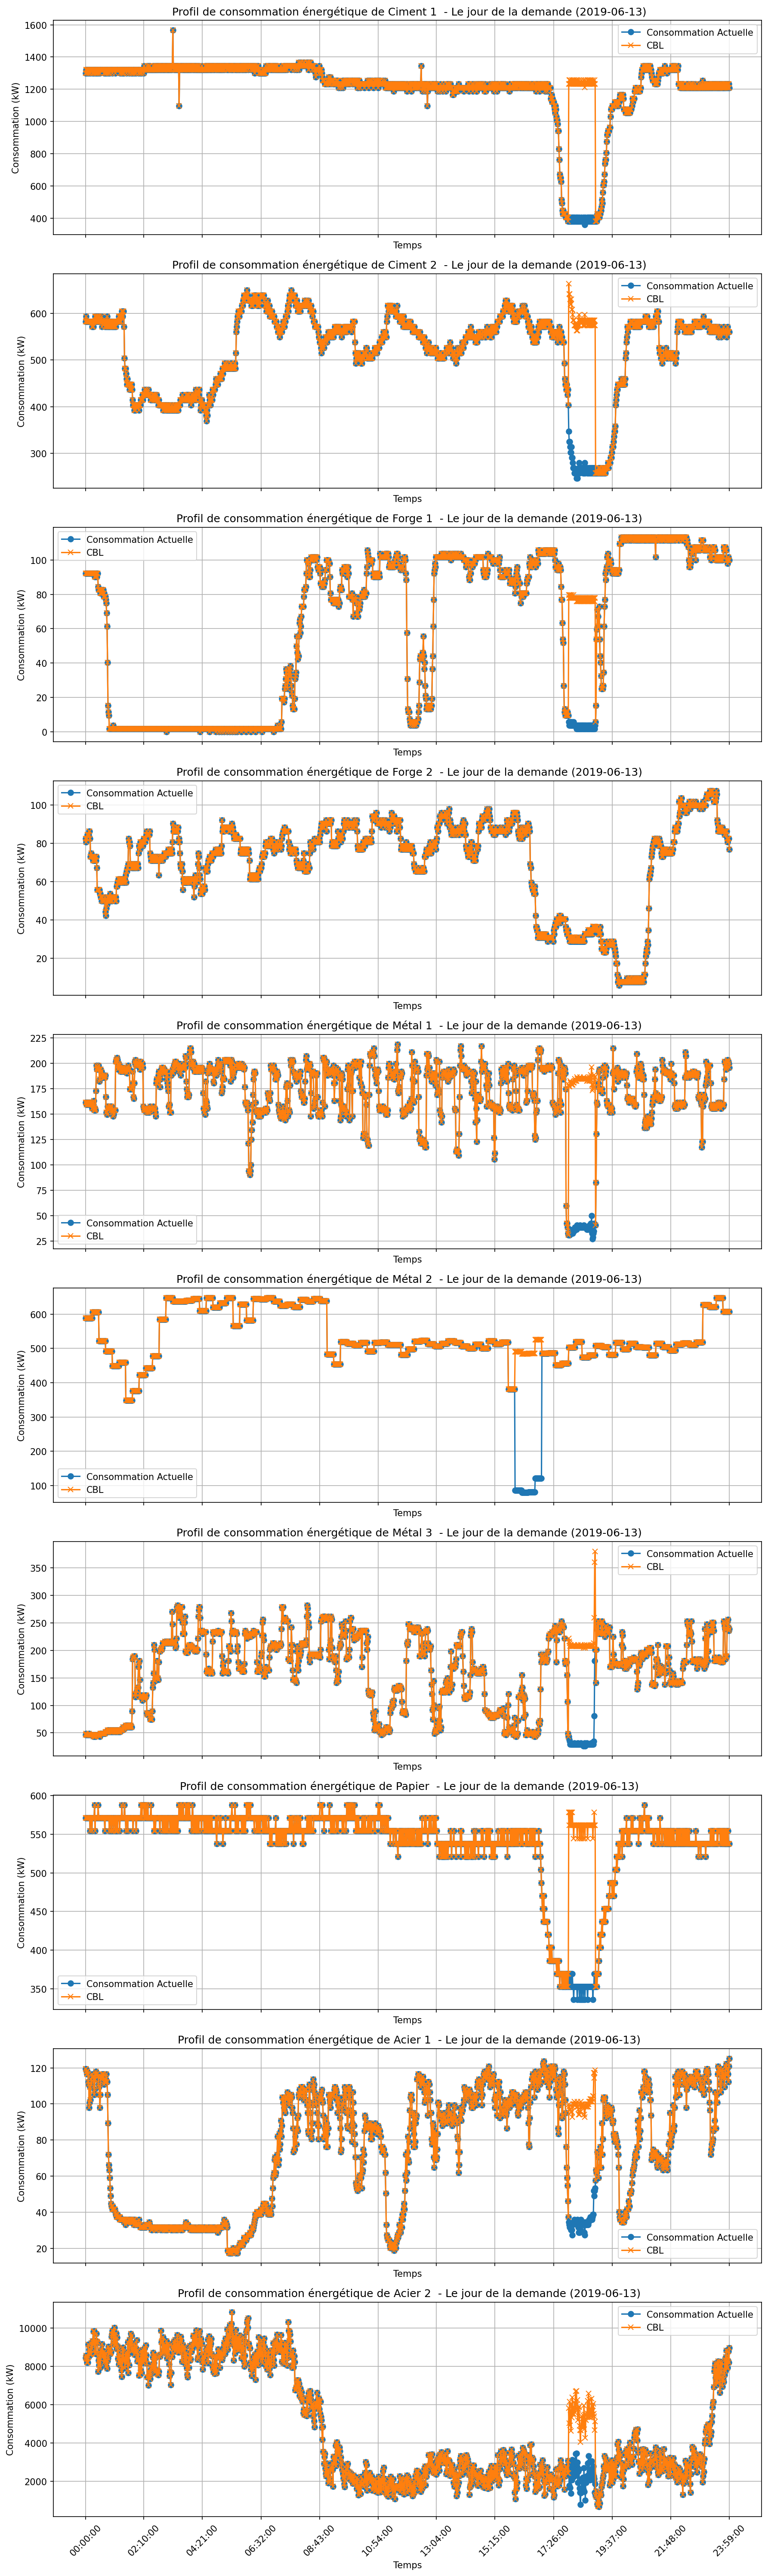

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set plot parameters for higher quality and white background
plt.rcParams['figure.dpi'] = 150  # Increase DPI for higher resolution
plt.rcParams['axes.facecolor'] = 'white'  # Set axes background color to white
plt.rcParams['savefig.facecolor'] = 'white'  # Set savefig background color to white

event_data['hms_str'] = event_data['hms'].astype(str)

factories = event_data['factory'].unique()
num_factories = len(factories)

fig, axes = plt.subplots(num_factories, 1, figsize=(12, 4 * num_factories), sharex=True)

for i, factory in enumerate(factories):
    factory_data = event_data[event_data['factory'] == factory]
    ax = axes[i]
    ax.plot(factory_data['hms_str'], factory_data['kW'], label='Consommation Actuelle', linestyle='-', marker='o')
    ax.plot(factory_data['hms_str'], factory_data['CBL'], label='CBL', linestyle='-', marker='x')
    ax.set_title(f' Profil de consommation énergétique de {factory_lab[factory]}  - Le jour de la demande (2019-06-13)')
    ax.set_xlabel('Temps')
    ax.set_ylabel('Consommation (kW)')
    ax.legend()
    ax.grid(True)

    # Set the x-ticks to be at evenly spaced intervals
    tick_positions = np.linspace(0, len(factory_data) - 1, num=12, dtype=int)  # Adjust the num parameter as needed
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(factory_data['hms_str'].iloc[tick_positions], rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
event_data['kW'] = event_data['CBL']

event_data.drop(columns=['CBL'], inplace=True)
event_data.drop(columns=['hms_str'], inplace=True)

In [ ]:
event_data.head()

dateTime      kW   factory       hms  hms_hours  weekDay  \
149760 2019-06-13 00:00:00  1299.2  Cement_1  00:00:00          0        3   
149761 2019-06-13 00:01:00  1321.6  Cement_1  00:01:00          0        3   
149762 2019-06-13 00:02:00  1321.6  Cement_1  00:02:00          0        3   
149763 2019-06-13 00:03:00  1299.2  Cement_1  00:03:00          0        3   
149764 2019-06-13 00:04:00  1321.6  Cement_1  00:04:00          0        3   

        Month        Date weekDayName  
149760      6  2019-06-13    Thursday  
149761      6  2019-06-13    Thursday  
149762      6  2019-06-13    Thursday  
149763      6  2019-06-13    Thursday  
149764      6  2019-06-13    Thursday

In [ ]:
import pandas as pd
from datetime import datetime

# Define the event day
event_day = datetime.strptime('2019-06-13', '%Y-%m-%d').date()

# Filter `event_data` for the specific event day
filtered_event_data = event_data[(event_data['Date'] == event_day)]

# Merge `all_data_imputed` with `filtered_event_data` on 'factory', 'Date', and 'hms'
merged_df = all_data_imputed.merge(filtered_event_data[['factory', 'Date', 'hms', 'kW']],
                                    on=['factory', 'Date', 'hms'],
                                    how='left',
                                    suffixes=('', '_event'))

# Update `kW` values in `all_data_imputed` with those from `event_data` where available
all_data_imputed['kW'] = merged_df['kW_event'].combine_first(merged_df['kW'])

# Verify the changes
print(all_data_imputed.head())


             dateTime      kW   factory       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00  1164.8  Cement_1  00:00:00          0        4      3   
1 2019-03-01 00:01:00  1142.4  Cement_1  00:01:00          0        4      3   
2 2019-03-01 00:02:00  1164.8  Cement_1  00:02:00          0        4      3   
3 2019-03-01 00:03:00  1142.4  Cement_1  00:03:00          0        4      3   
4 2019-03-01 00:04:00  1164.8  Cement_1  00:04:00          0        4      3   

         Date weekDayName  
0  2019-03-01      Friday  
1  2019-03-01      Friday  
2  2019-03-01      Friday  
3  2019-03-01      Friday  
4  2019-03-01      Friday  


In [ ]:
print(all_data_imputed[(all_data_imputed['Date']== datetime.strptime('2019-06-13', '%Y-%m-%d').date()) & ((all_data_imputed['hms_hours'] == 18))])

                   dateTime           kW   factory       hms  hms_hours  \
150840  2019-06-13 18:00:00  1234.100000  Cement_1  18:00:00         18   
150841  2019-06-13 18:01:00  1256.500000  Cement_1  18:01:00         18   
150842  2019-06-13 18:02:00  1234.100000  Cement_1  18:02:00         18   
150843  2019-06-13 18:03:00  1256.500000  Cement_1  18:03:00         18   
150844  2019-06-13 18:04:00  1234.100000  Cement_1  18:04:00         18   
...                     ...          ...       ...       ...        ...   
2924335 2019-06-13 18:55:00  6037.676167   Steel_2  18:55:00         18   
2924336 2019-06-13 18:56:00  5530.326167   Steel_2  18:56:00         18   
2924337 2019-06-13 18:57:00  5398.896167   Steel_2  18:57:00         18   
2924338 2019-06-13 18:58:00  4671.596167   Steel_2  18:58:00         18   
2924339 2019-06-13 18:59:00  5108.816167   Steel_2  18:59:00         18   

         weekDay  Month        Date weekDayName  
150840         3      6  2019-06-13    Thursday  

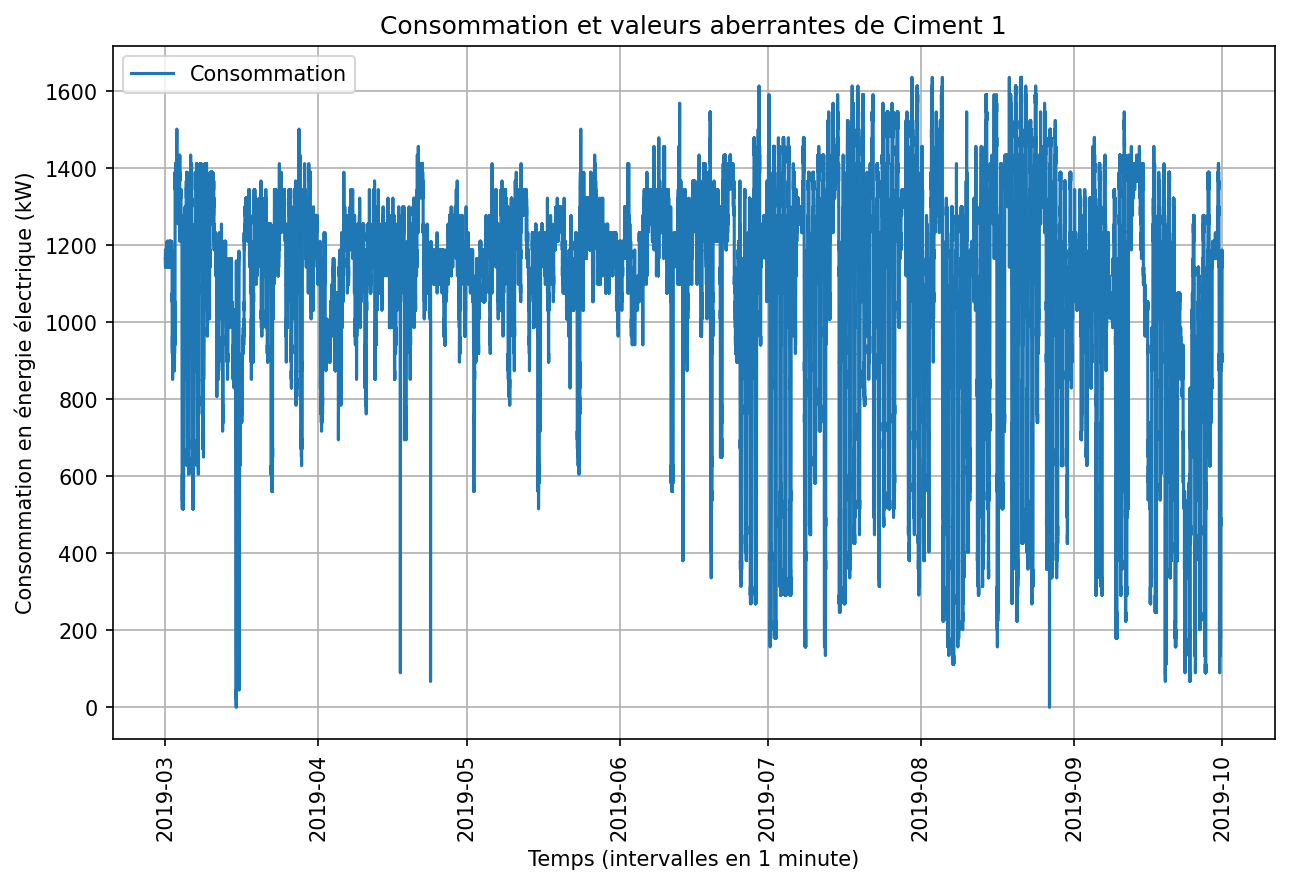

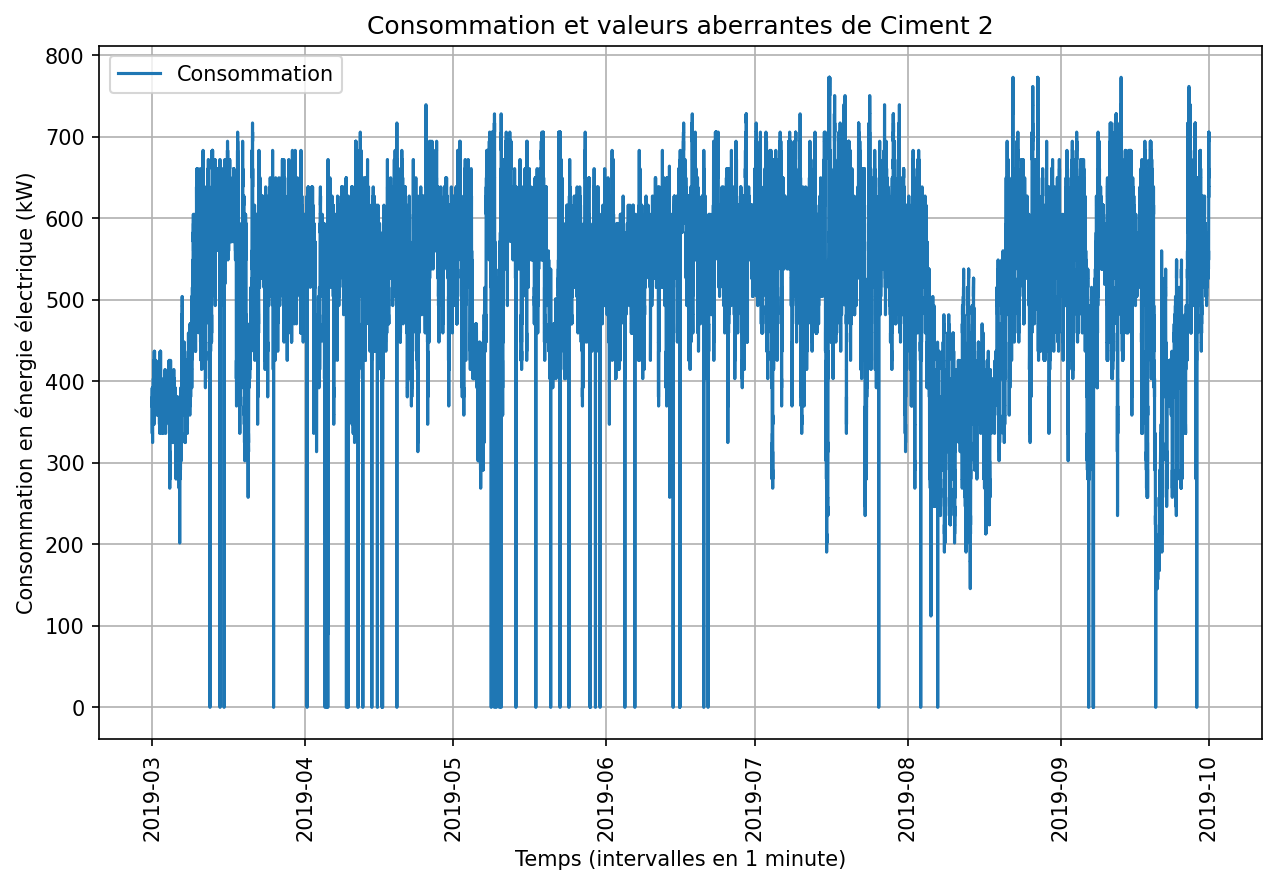

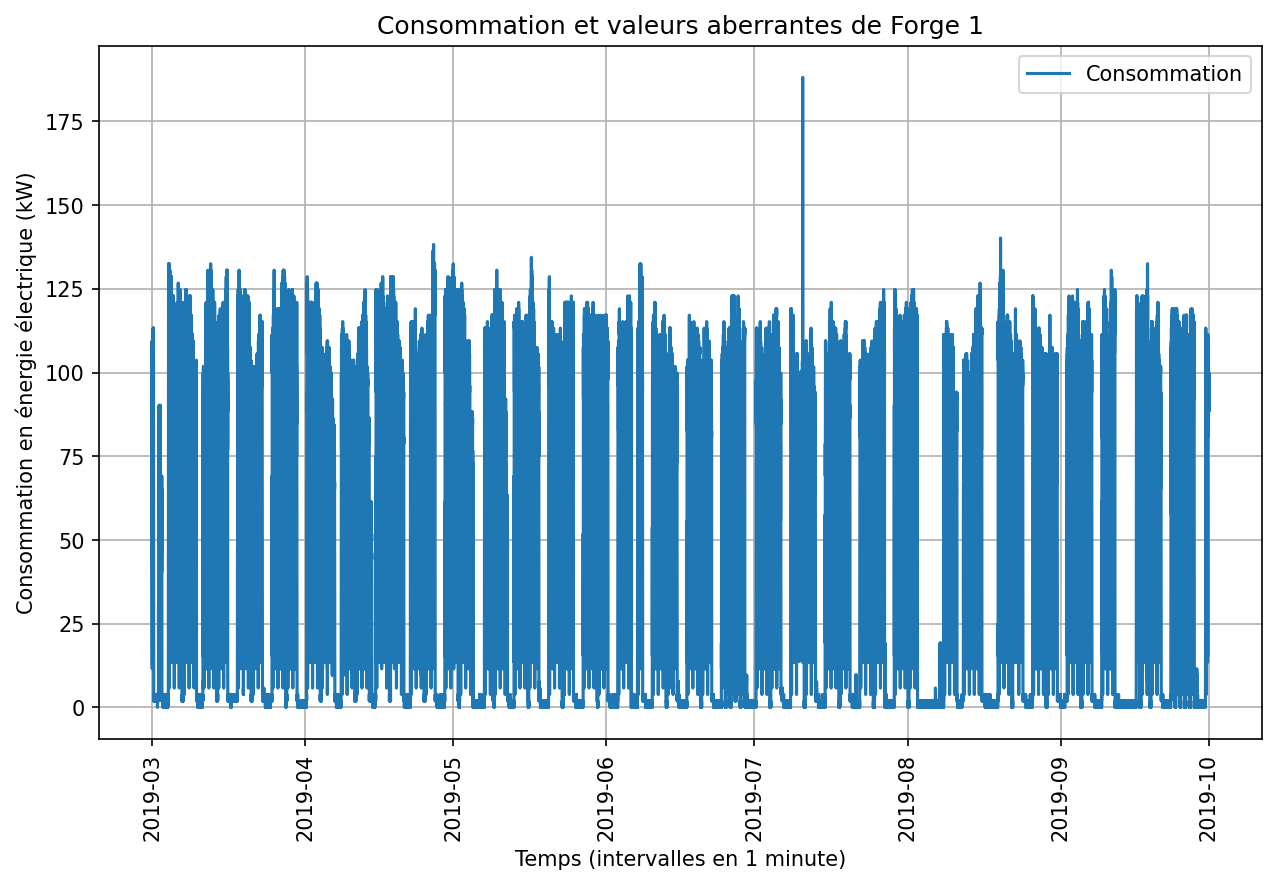

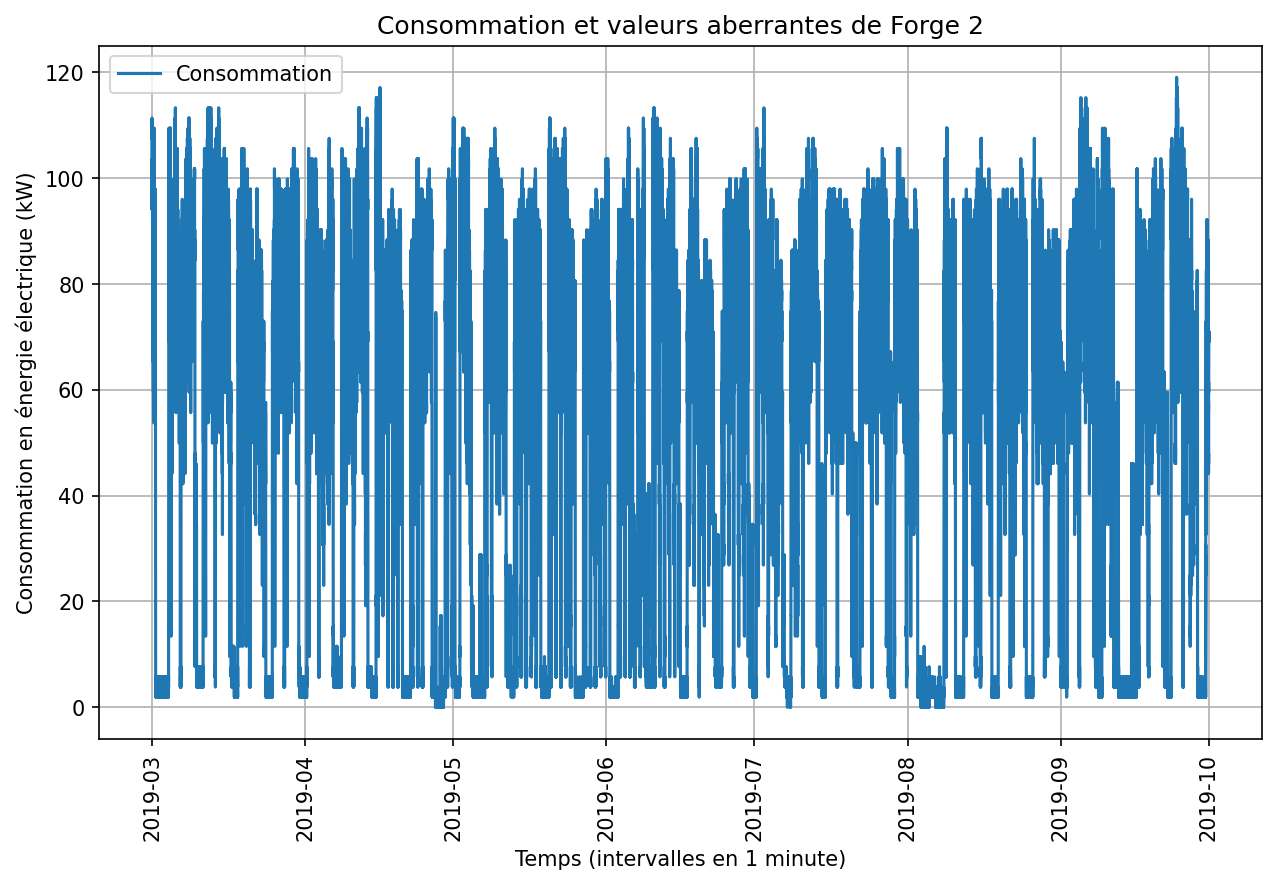

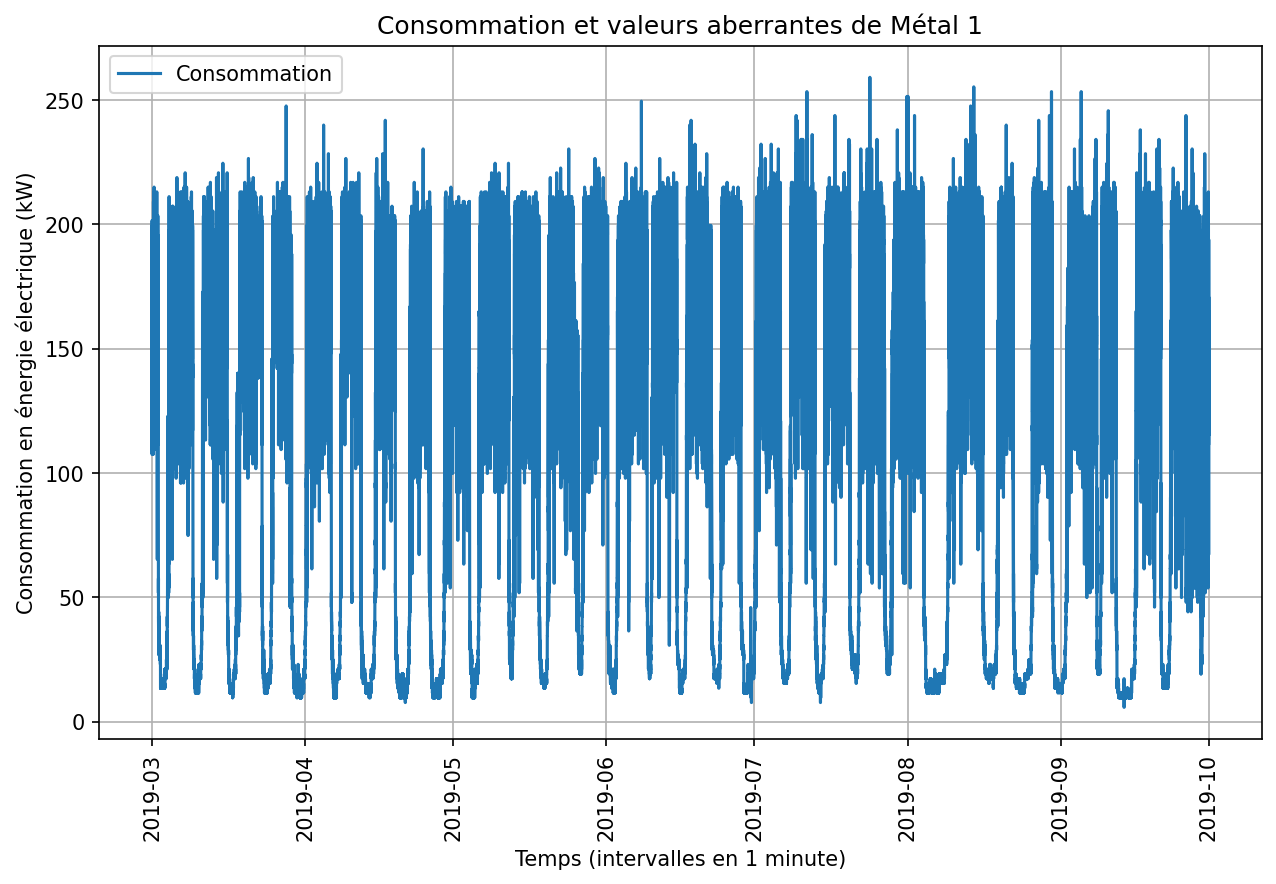

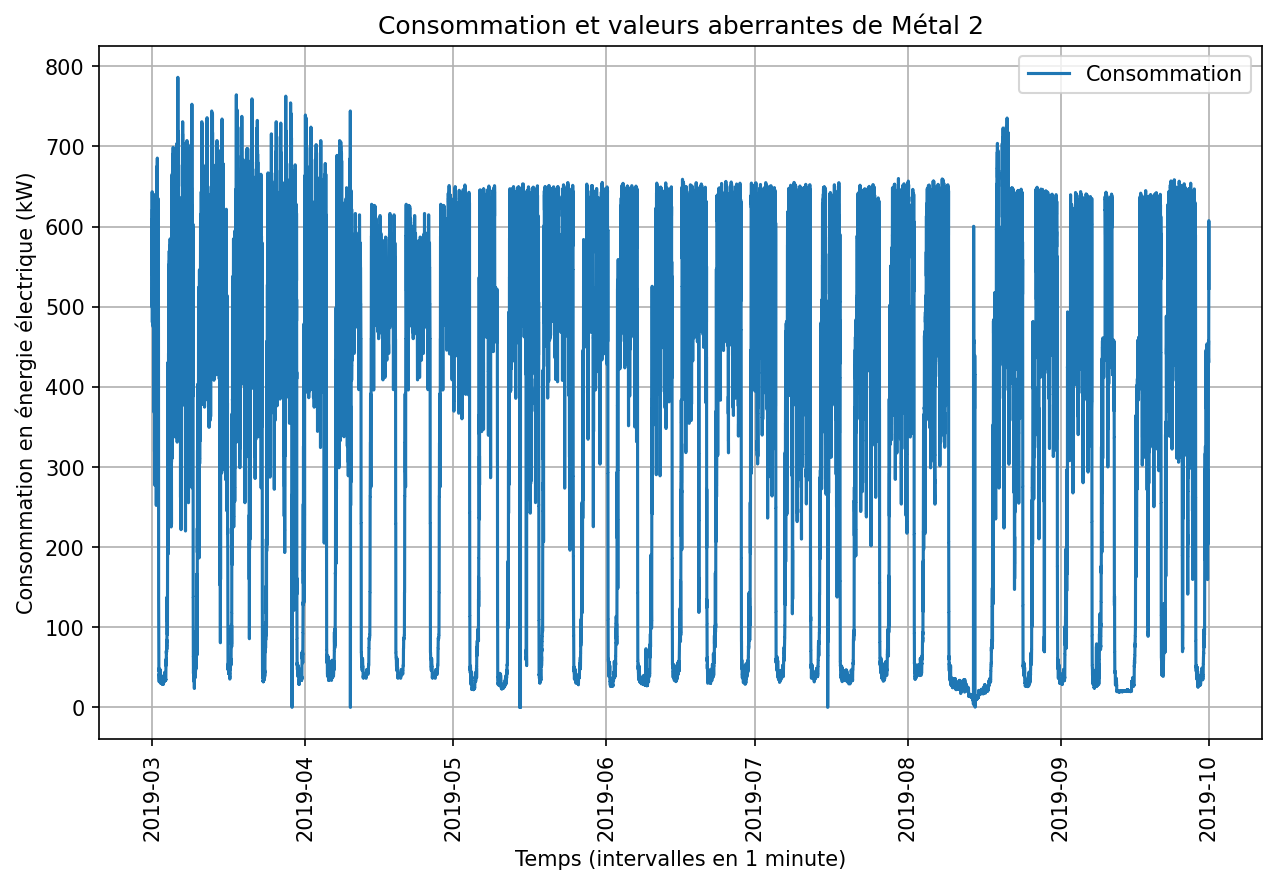

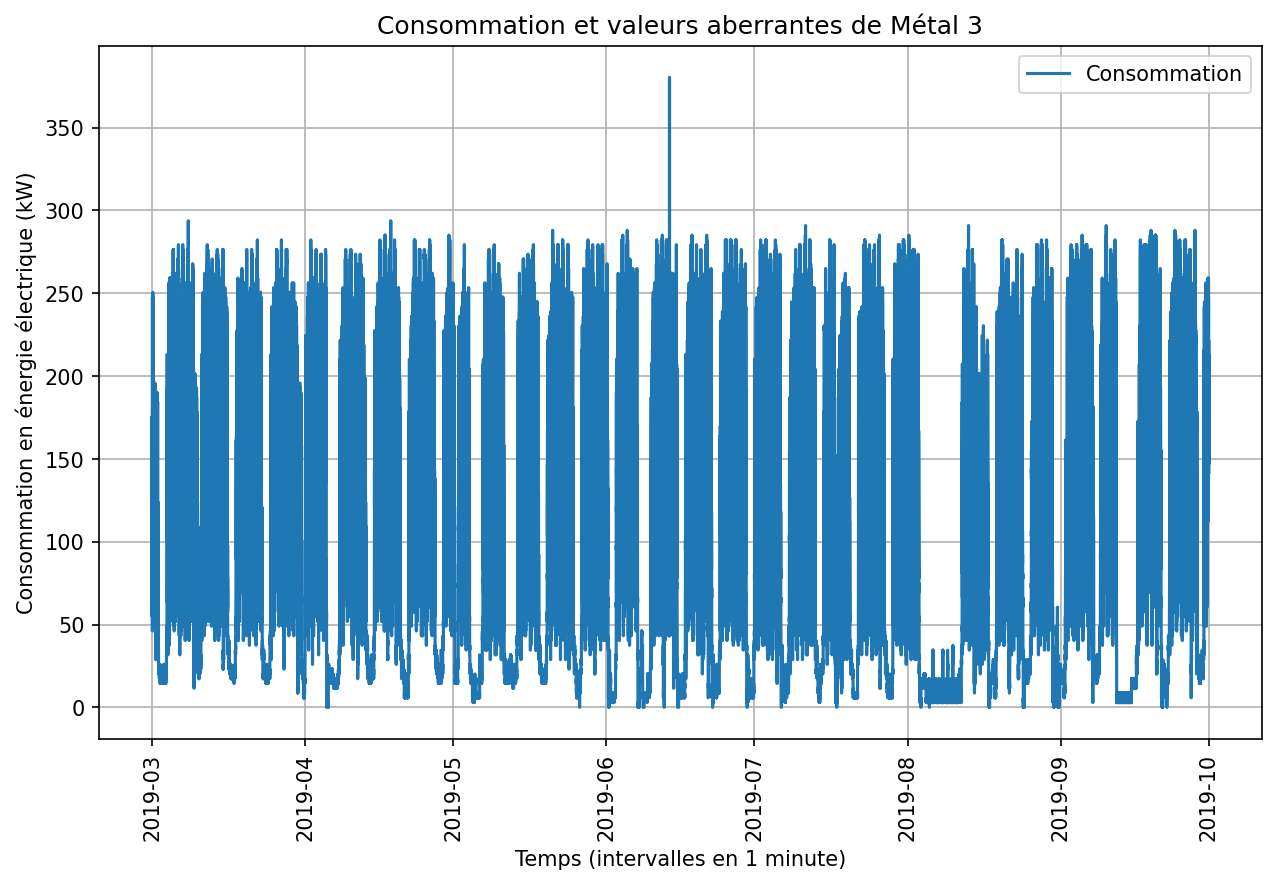

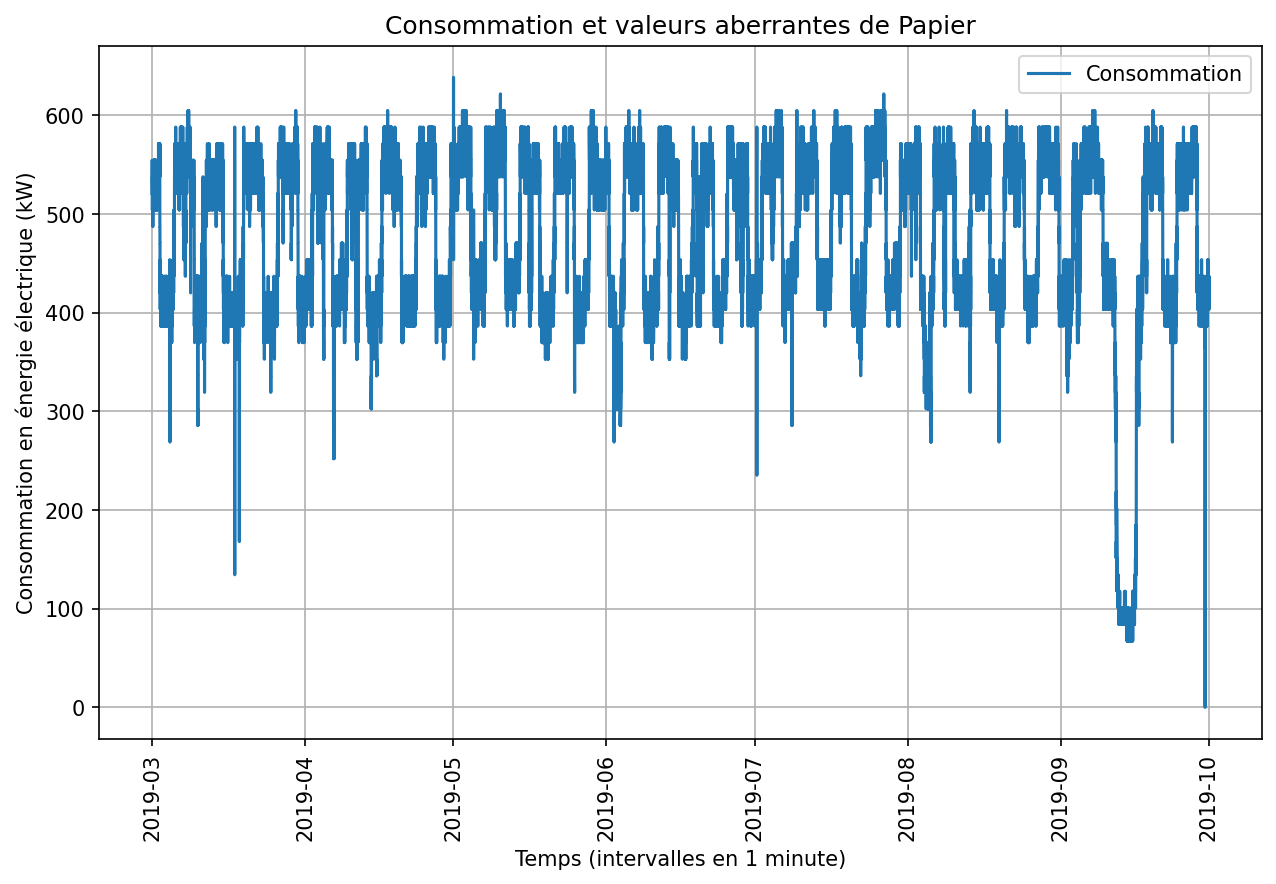

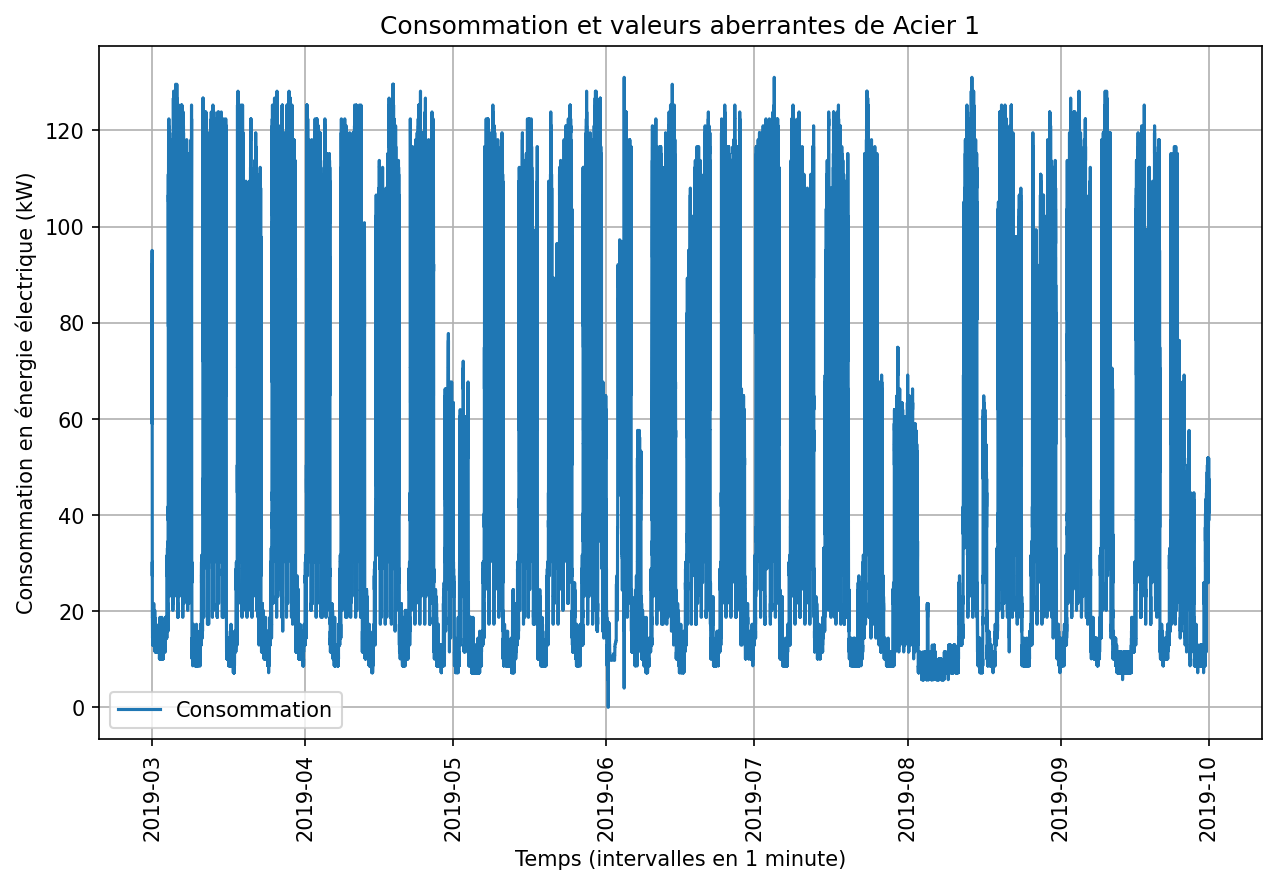

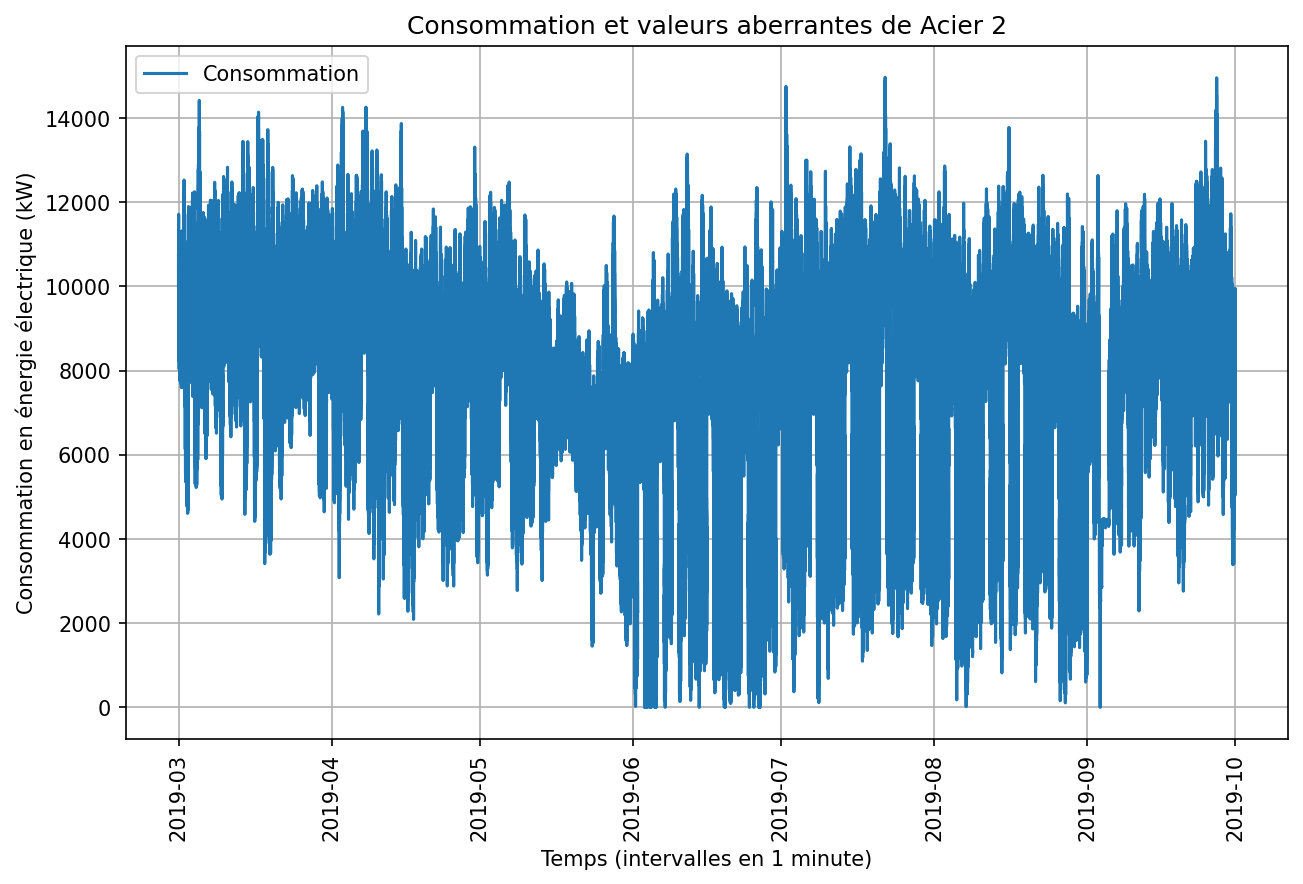

In [ ]:
for idx, factory in enumerate(factories):
    plt.figure(figsize=(10, 6))
    factory_data = all_data_imputed[all_data_imputed['factory'] == factory]
    plt.plot(factory_data['dateTime'], factory_data['kW'], label='Consommation')
    plt.xlabel('Temps (intervalles en 1 minute)')
    plt.ylabel('Consommation en énergie électrique (kW)')
    plt.title(f'Consommation et valeurs aberrantes de {factory_lab[factory]}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.show()

# **III. Demande du systéme**

In [ ]:
file_path = '/content/drive/My Drive/Dataset/System_demand/Systemload(Korea, 2019.03~06.).csv'

system_demand = pd.read_csv(file_path, parse_dates=['time'])

system_demand['dateTime'] = pd.to_datetime(system_demand['time'])

system_demand.set_index('dateTime', inplace=True)

full_range = pd.date_range(start='2019-03-01 00:00:00', end='2019-10-01 00:00:00', freq='5T')

full_range_df = pd.DataFrame(index=full_range)

system_demand_expanded = full_range_df.join(system_demand, how='left')

missing_intervals = system_demand_expanded[system_demand_expanded['system_demand'].isna()].index

print(f'Number of missing 5-minute intervals: {len(missing_intervals)}')
print('Missing 5-minute intervals:')
print(missing_intervals)

Number of missing 5-minute intervals: 10
Missing 5-minute intervals:
DatetimeIndex(['2019-05-14 14:10:00', '2019-05-17 09:15:00',
               '2019-06-21 06:00:00', '2019-07-27 12:20:00',
               '2019-08-20 15:10:00', '2019-09-22 18:30:00',
               '2019-09-24 23:55:00', '2019-09-30 01:20:00',
               '2019-09-30 14:00:00', '2019-10-01 00:00:00'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
system_demand.head()

time  system_demand
dateTime                                              
2019-03-01 00:00:00 2019-03-01 00:00:00        65213.4
2019-03-01 00:05:00 2019-03-01 00:05:00        64479.1
2019-03-01 00:10:00 2019-03-01 00:10:00        64131.5
2019-03-01 00:15:00 2019-03-01 00:15:00        63653.3
2019-03-01 00:20:00 2019-03-01 00:20:00        63301.4

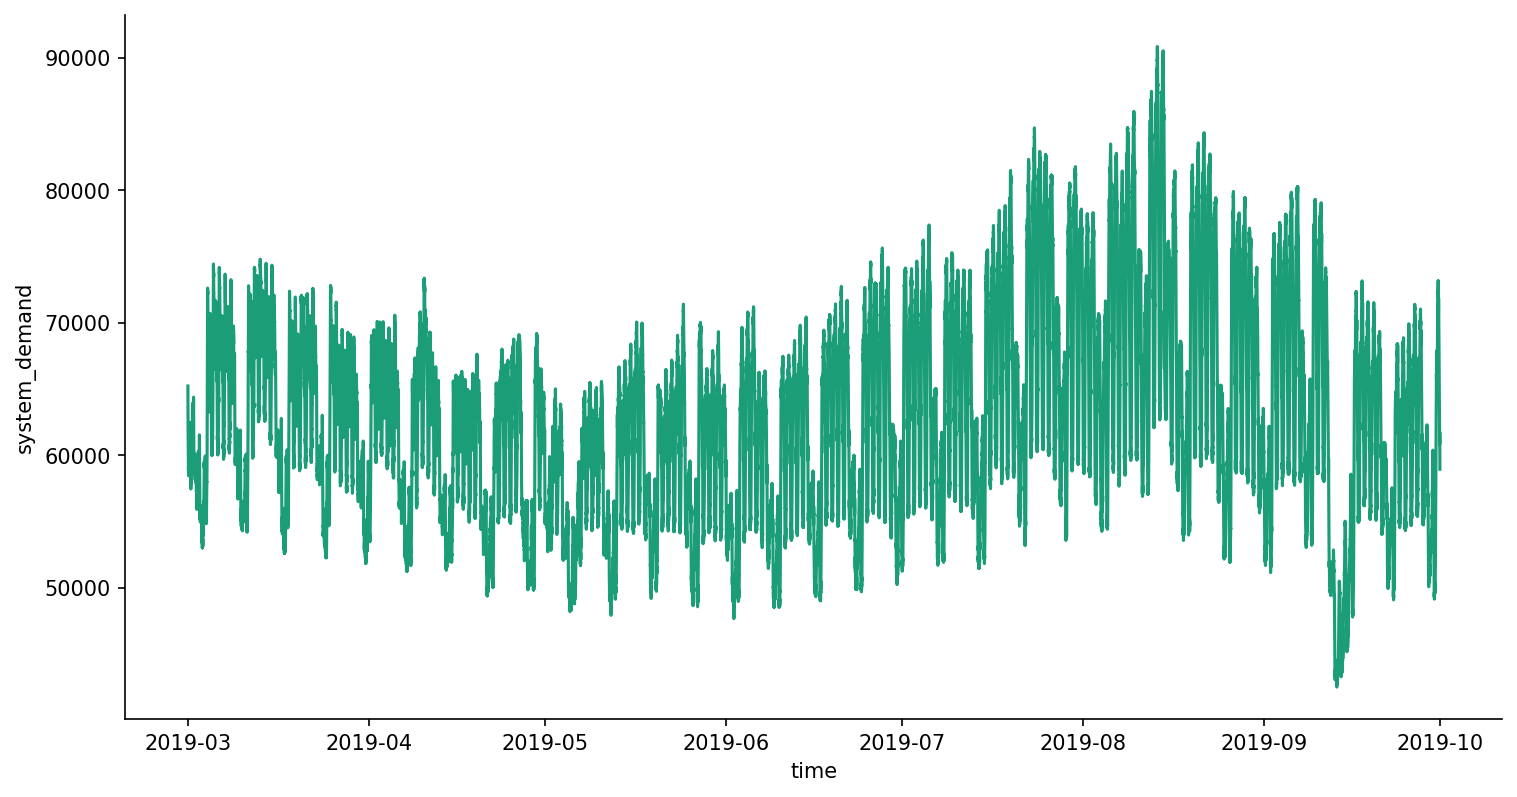

In [ ]:
# @title time vs system_demand

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['system_demand']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = system_demand.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('system_demand')

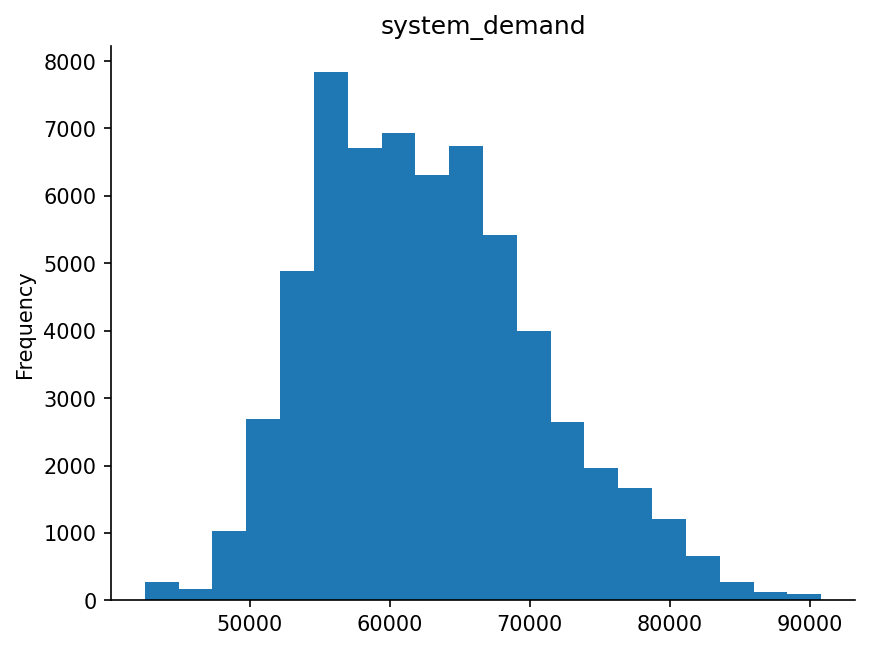

In [ ]:
# @title system_demand

from matplotlib import pyplot as plt
system_demand['system_demand'].plot(kind='hist', bins=20, title='system_demand')
plt.gca().spines[['top', 'right',]].set_visible(False)

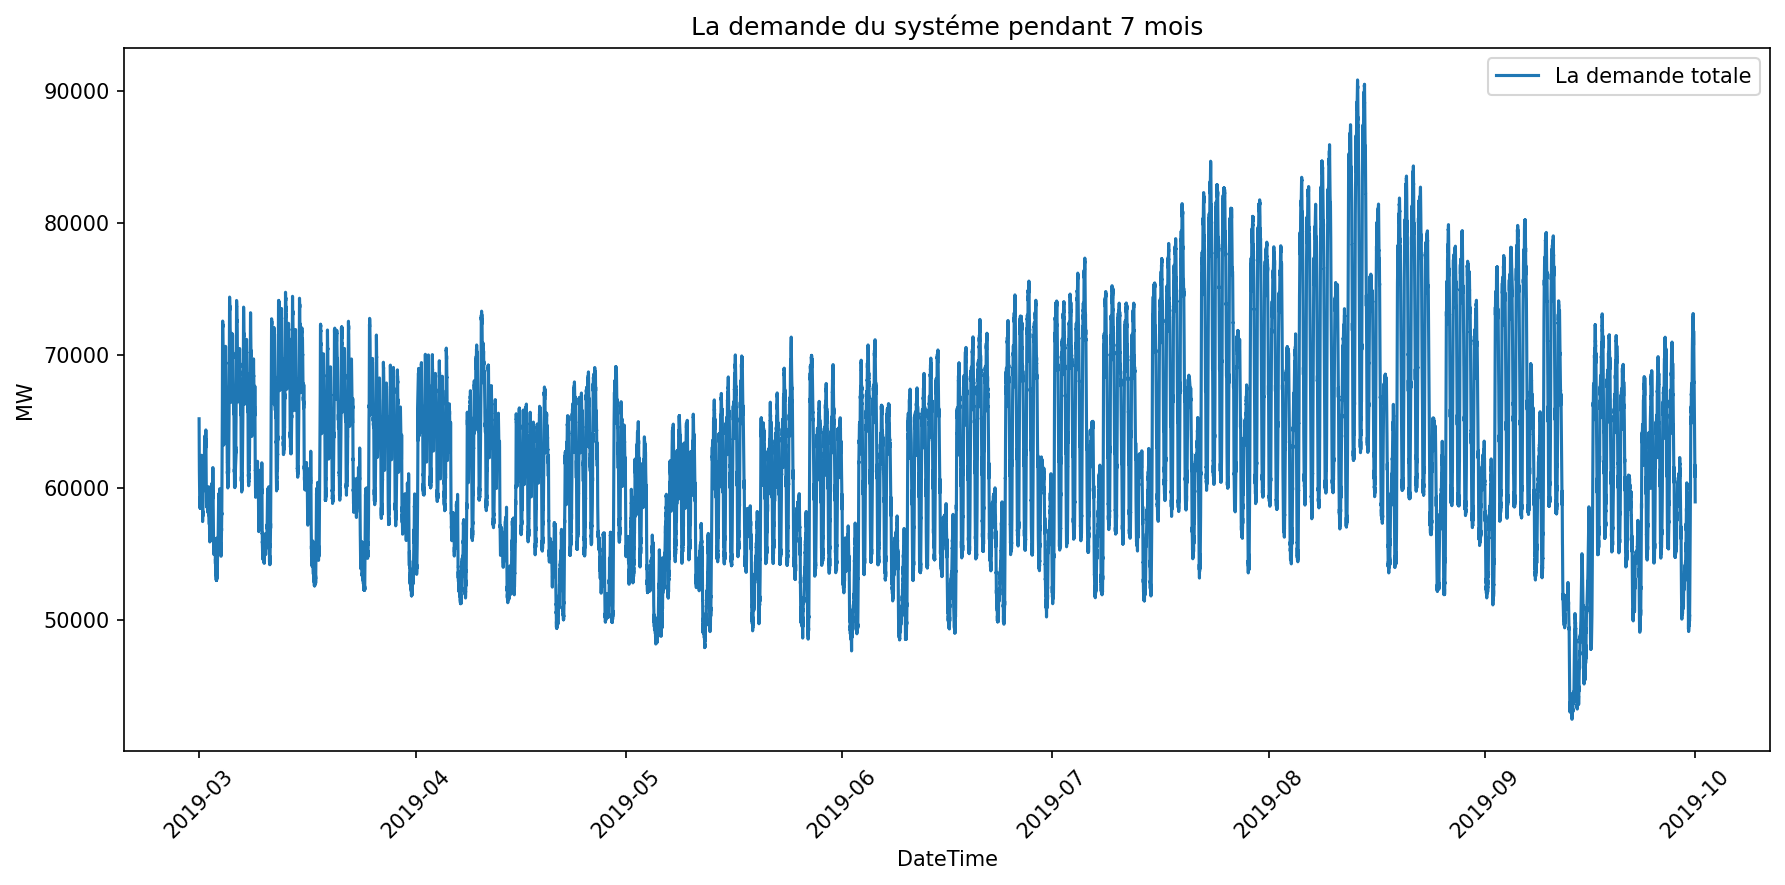

In [ ]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(system_demand.index, system_demand['system_demand'], label='La demande totale')

plt.xlabel('DateTime')
plt.ylabel('MW')
plt.title('La demande du systéme pendant 7 mois')

plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

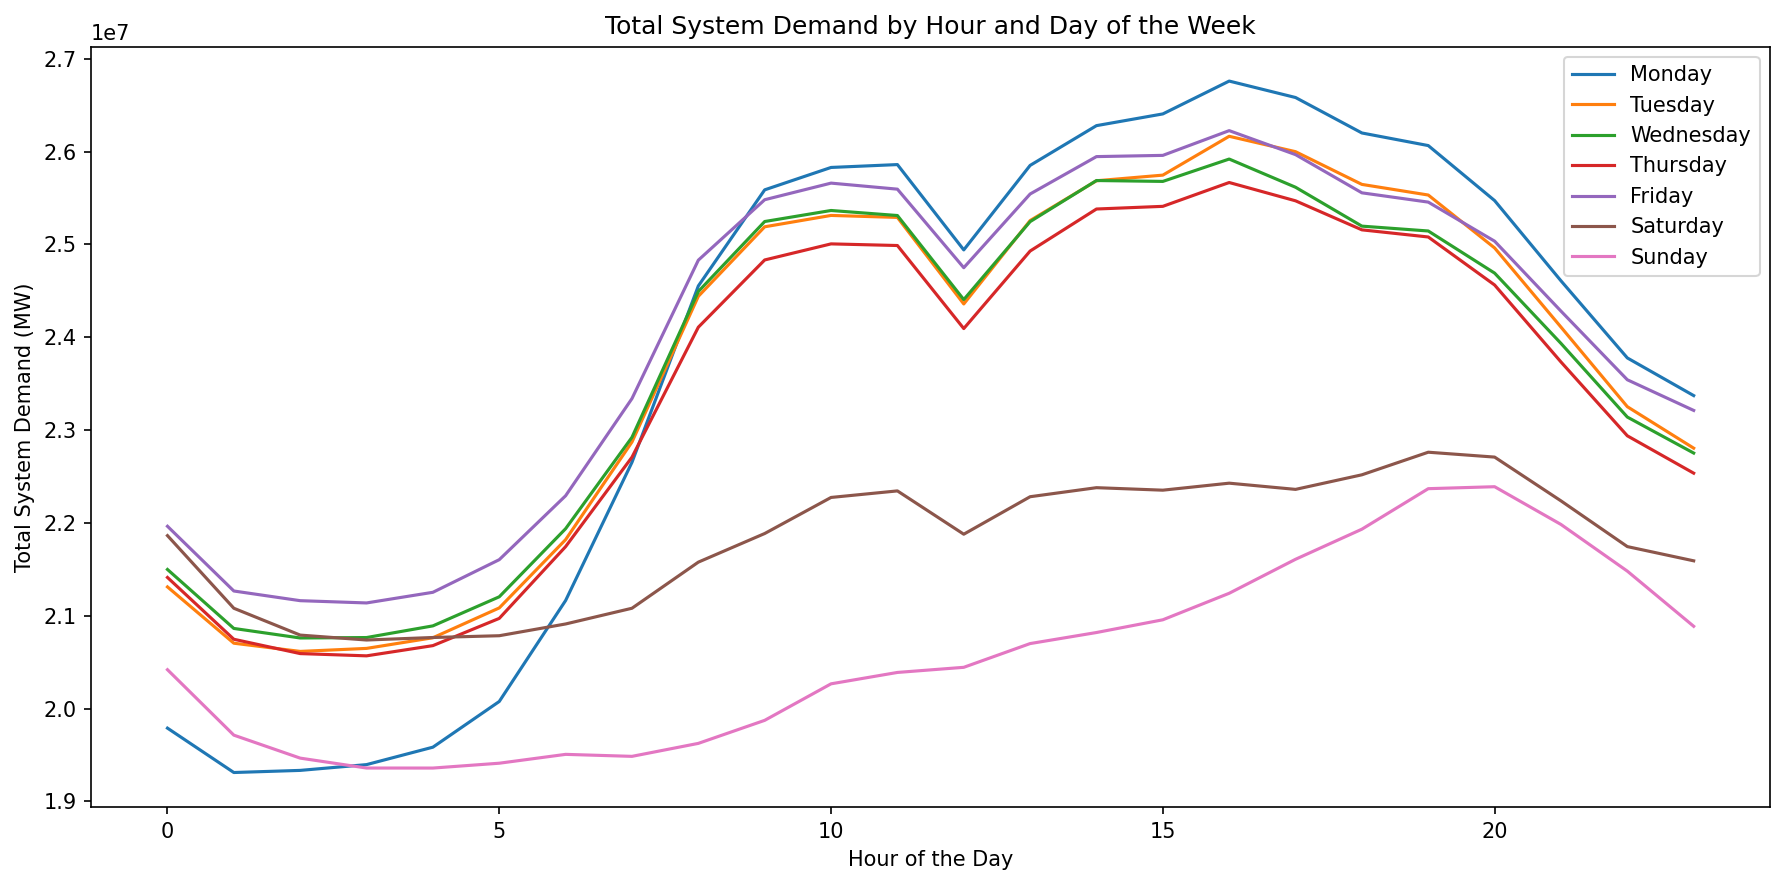

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

system_demand_copy = system_demand.copy()

system_demand_copy['weekDay'] = system_demand_copy.index.dayofweek
system_demand_copy['hour'] = system_demand_copy.index.hour

total_demand_by_day_hour = system_demand_copy.groupby(['weekDay', 'hour'])['system_demand'].sum().unstack(level=0)

plt.figure(figsize=(12, 6))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, weekday in enumerate(weekdays):
    plt.plot(total_demand_by_day_hour.index, total_demand_by_day_hour[i], label=weekday)

plt.xlabel('Hour of the Day')
plt.ylabel('Total System Demand (MW)')
plt.title('Total System Demand by Hour and Day of the Week')

plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Impute missing values with backward fill
system_demand_imputed = system_demand_expanded.bfill()

# Check if there are any remaining missing values
remaining_missing = system_demand_imputed[system_demand_imputed['system_demand'].isna()]

print(f'Number of remaining missing 5-minute intervals: {len(remaining_missing)}')
print('Remaining missing 5-minute intervals:')
print(remaining_missing)


Number of remaining missing 5-minute intervals: 1
Remaining missing 5-minute intervals:
           time  system_demand
2019-10-01  NaT            NaN


In [ ]:
system_demand_imputed.head()

time  system_demand
2019-03-01 00:00:00 2019-03-01 00:00:00        65213.4
2019-03-01 00:05:00 2019-03-01 00:05:00        64479.1
2019-03-01 00:10:00 2019-03-01 00:10:00        64131.5
2019-03-01 00:15:00 2019-03-01 00:15:00        63653.3
2019-03-01 00:20:00 2019-03-01 00:20:00        63301.4

In [ ]:
system_demand_resampled = system_demand_expanded.resample('1T').ffill()

system_demand_resampled['system_demand'] = system_demand_resampled['system_demand'] / 5.0

system_demand_resampled.head()

time  system_demand
2019-03-01 00:00:00 2019-03-01       13042.68
2019-03-01 00:01:00 2019-03-01       13042.68
2019-03-01 00:02:00 2019-03-01       13042.68
2019-03-01 00:03:00 2019-03-01       13042.68
2019-03-01 00:04:00 2019-03-01       13042.68

In [ ]:
system_demand_resampled.tail()

time  system_demand
2019-09-30 23:56:00 2019-09-30 23:55:00       11785.68
2019-09-30 23:57:00 2019-09-30 23:55:00       11785.68
2019-09-30 23:58:00 2019-09-30 23:55:00       11785.68
2019-09-30 23:59:00 2019-09-30 23:55:00       11785.68
2019-10-01 00:00:00                 NaT            NaN

In [ ]:
system_demand_resampled.drop(columns=['time'], inplace=True)

In [ ]:
# Drop the last row
system_demand_resampled = system_demand_resampled[:-1]

print(system_demand_resampled.tail())

                     system_demand
2019-09-30 23:55:00       11785.68
2019-09-30 23:56:00       11785.68
2019-09-30 23:57:00       11785.68
2019-09-30 23:58:00       11785.68
2019-09-30 23:59:00       11785.68


In [ ]:
system_demand_resampled.isnull().sum()

system_demand    45
dtype: int64

In [ ]:
system_demand_resampled.fillna(method='ffill', inplace=True)

<ipython-input-61-8c0db0fc9656>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  system_demand_resampled.fillna(method='ffill', inplace=True)


In [ ]:
system_demand_resampled.isnull().sum()

system_demand    0
dtype: int64

In [ ]:
all_data_imputed.set_index('dateTime', inplace=True)

all_data_combined = all_data_imputed.join(system_demand_resampled['system_demand'])

all_data_combined.reset_index(inplace=True)

all_data_combined.head()

dateTime       kW   factory       hms  hms_hours  weekDay  Month  \
0 2019-03-01  1164.80  Cement_1  00:00:00          0        4      3   
1 2019-03-01   369.60  Cement_2  00:00:00          0        4      3   
2 2019-03-01    86.40   Forge_1  00:00:00          0        4      3   
3 2019-03-01   107.52   Forge_2  00:00:00          0        4      3   
4 2019-03-01   184.32   Metal_1  00:00:00          0        4      3   

         Date weekDayName  system_demand  
0  2019-03-01      Friday       13042.68  
1  2019-03-01      Friday       13042.68  
2  2019-03-01      Friday       13042.68  
3  2019-03-01      Friday       13042.68  
4  2019-03-01      Friday       13042.68

In [ ]:
all_data_combined['system_demand'] = all_data_combined['system_demand'] * 1000
all_data_combined.rename(columns={'kW': 'FactoryCons', 'system_demand': 'TotalCons'}, inplace=True)
all_data_combined.head()

dateTime  FactoryCons   factory       hms  hms_hours  weekDay  Month  \
0 2019-03-01      1164.80  Cement_1  00:00:00          0        4      3   
1 2019-03-01       369.60  Cement_2  00:00:00          0        4      3   
2 2019-03-01        86.40   Forge_1  00:00:00          0        4      3   
3 2019-03-01       107.52   Forge_2  00:00:00          0        4      3   
4 2019-03-01       184.32   Metal_1  00:00:00          0        4      3   

         Date weekDayName   TotalCons  
0  2019-03-01      Friday  13042680.0  
1  2019-03-01      Friday  13042680.0  
2  2019-03-01      Friday  13042680.0  
3  2019-03-01      Friday  13042680.0  
4  2019-03-01      Friday  13042680.0

# **IV. Préparation des données**

In [ ]:
all_data_combined['dateTime'] = pd.to_datetime(all_data_combined['dateTime'])

all_data_combined['month'] = all_data_combined['dateTime'].dt.month
all_data_combined['day'] = all_data_combined['dateTime'].dt.day
all_data_combined['hour'] = all_data_combined['dateTime'].dt.hour
all_data_combined['minute'] = all_data_combined['dateTime'].dt.minute
all_data_combined['day_of_week'] = all_data_combined['dateTime'].dt.dayofweek

#all_data_combined.drop(columns=['Date', 'weekDay', 'hms_hours', 'hms', 'Month'], inplace=True)

all_data_combined.head()

dateTime  FactoryCons   factory       hms  hms_hours  weekDay  Month  \
0 2019-03-01      1164.80  Cement_1  00:00:00          0        4      3   
1 2019-03-01       369.60  Cement_2  00:00:00          0        4      3   
2 2019-03-01        86.40   Forge_1  00:00:00          0        4      3   
3 2019-03-01       107.52   Forge_2  00:00:00          0        4      3   
4 2019-03-01       184.32   Metal_1  00:00:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       0            4  
2  2019-03-01      Friday  13042680.0      3    1     0       0            4  
3  2019-03-01      Friday  13042680.0      3    1     0       0            4  
4  2019-03-01      Friday  13042680.0      3    1     0       0            4

In [ ]:
all_data_combined.dtypes

dateTime       datetime64[ns]
FactoryCons           float64
factory                object
hms                    object
hms_hours               int32
weekDay                 int32
Month                   int32
Date                   object
weekDayName            object
TotalCons             float64
month                   int32
day                     int32
hour                    int32
minute                  int32
day_of_week             int32
dtype: object

In [ ]:
"""from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
time_features = ['hour', 'minute', 'day_of_week']
all_data_combined[time_features] = scaler.fit_transform(all_data_combined[time_features])

# Encode cyclical features
def encode_cyclical_feature(df, column, max_value):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_value)
    df.drop(columns=[column], inplace=True)

encode_cyclical_feature(all_data_combined, 'hour', 24)
encode_cyclical_feature(all_data_combined, 'day_of_week', 7)

all_data_combined.head()

dateTime  FactoryCons   factory weekDayName   TotalCons  month  day  \
0 2019-03-01      1164.80  Cement_1      Friday  13042680.0      3    1   
1 2019-03-01       369.60  Cement_2      Friday  13042680.0      3    1   
2 2019-03-01        86.40   Forge_1      Friday  13042680.0      3    1   
3 2019-03-01       107.52   Forge_2      Friday  13042680.0      3    1   
4 2019-03-01       184.32   Metal_1      Friday  13042680.0      3    1   

   minute  hour_sin  hour_cos  day_of_week_sin  day_of_week_cos  
0     0.0       0.0       1.0          0.56332         0.826239  
1     0.0       0.0       1.0          0.56332         0.826239  
2     0.0       0.0       1.0          0.56332         0.826239  
3     0.0       0.0       1.0          0.56332         0.826239  
4     0.0       0.0       1.0          0.56332         0.826239

In [ ]:

all_data_combined['dateTime'] = pd.to_datetime(all_data_combined['dateTime'])
all_data_combined.head()

dateTime  FactoryCons   factory       hms  hms_hours  weekDay  Month  \
0 2019-03-01      1164.80  Cement_1  00:00:00          0        4      3   
1 2019-03-01       369.60  Cement_2  00:00:00          0        4      3   
2 2019-03-01        86.40   Forge_1  00:00:00          0        4      3   
3 2019-03-01       107.52   Forge_2  00:00:00          0        4      3   
4 2019-03-01       184.32   Metal_1  00:00:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       0            4  
2  2019-03-01      Friday  13042680.0      3    1     0       0            4  
3  2019-03-01      Friday  13042680.0      3    1     0       0            4  
4  2019-03-01      Friday  13042680.0      3    1     0       0            4

# **V. Extraction des données**

In [ ]:
all_data_combined.tail()

dateTime  FactoryCons  factory       hms  hms_hours  \
3081595 2019-09-30 23:59:00       522.90  Metal_2  23:59:00         23   
3081596 2019-09-30 23:59:00       210.24  Metal_3  23:59:00         23   
3081597 2019-09-30 23:59:00       420.00    Paper  23:59:00         23   
3081598 2019-09-30 23:59:00        41.76  Steel_1  23:59:00         23   
3081599 2019-09-30 23:59:00      8849.84  Steel_2  23:59:00         23   

         weekDay  Month        Date weekDayName   TotalCons  month  day  hour  \
3081595        0      9  2019-09-30      Monday  11785680.0      9   30    23   
3081596        0      9  2019-09-30      Monday  11785680.0      9   30    23   
3081597        0      9  2019-09-30      Monday  11785680.0      9   30    23   
3081598        0      9  2019-09-30      Monday  11785680.0      9   30    23   
3081599        0      9  2019-09-30      Monday  11785680.0      9   30    23   

         minute  day_of_week  
3081595      59            0  
3081596      59            0  
3081597      59            0  
3081598      59            0  
3081599      59            0

In [ ]:
all_data_combined.drop(columns=['Date', 'weekDay', 'hms_hours', 'hms', 'Month', 'weekDayName'], inplace=True)
all_data_combined.head()

dateTime  FactoryCons   factory   TotalCons  month  day  hour  minute  \
0 2019-03-01      1164.80  Cement_1  13042680.0      3    1     0       0   
1 2019-03-01       369.60  Cement_2  13042680.0      3    1     0       0   
2 2019-03-01        86.40   Forge_1  13042680.0      3    1     0       0   
3 2019-03-01       107.52   Forge_2  13042680.0      3    1     0       0   
4 2019-03-01       184.32   Metal_1  13042680.0      3    1     0       0   

   day_of_week  
0            4  
1            4  
2            4  
3            4  
4            4

In [ ]:
save_path = '/content/drive/My Drive/Dataset/Training/all_data.csv'
os.makedirs('/content/drive/My Drive/Dataset/Training', exist_ok=True)
all_data_combined.to_csv(save_path, index=False)
print(f"DataFrame sauvegardé sous {save_path}")

DataFrame sauvegardé sous /content/drive/My Drive/Dataset/Training/all_data.csv


In [ ]:
base_dir = '/content/drive/My Drive/Dataset'
factories_dir = os.path.join(base_dir, 'Training', 'Factories')

os.makedirs(factories_dir, exist_ok=True)

factory_dataframes = {}

for factory in all_data_combined['factory'].unique():
    factory_dataframes[factory] = all_data_combined[all_data_combined['factory'] == factory]

for factory, df in factory_dataframes.items():
    df = df.drop(columns=['factory'])
    factory_file_path = os.path.join(factories_dir, f'{factory}.csv')
    df.to_csv(factory_file_path, index=False)
    print(f"Data for {factory} saved to {factory_file_path}")

Data for Cement_1 saved to /content/drive/My Drive/Dataset/Training/Factories/Cement_1.csv
Data for Cement_2 saved to /content/drive/My Drive/Dataset/Training/Factories/Cement_2.csv
Data for Forge_1 saved to /content/drive/My Drive/Dataset/Training/Factories/Forge_1.csv
Data for Forge_2 saved to /content/drive/My Drive/Dataset/Training/Factories/Forge_2.csv
Data for Metal_1 saved to /content/drive/My Drive/Dataset/Training/Factories/Metal_1.csv
Data for Metal_2 saved to /content/drive/My Drive/Dataset/Training/Factories/Metal_2.csv
Data for Metal_3 saved to /content/drive/My Drive/Dataset/Training/Factories/Metal_3.csv
Data for Paper saved to /content/drive/My Drive/Dataset/Training/Factories/Paper.csv
Data for Steel_1 saved to /content/drive/My Drive/Dataset/Training/Factories/Steel_1.csv
Data for Steel_2 saved to /content/drive/My Drive/Dataset/Training/Factories/Steel_2.csv


In [ ]:
Cement_1_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Cement_1" + ".csv"))
Cement_1_data = pd.concat([Cement_1_data, df], ignore_index=True)
Cement_1_data['dateTime'] = pd.to_datetime(Cement_1_data['dateTime'])
Cement_1_data.head()

dateTime  FactoryCons   TotalCons  month  day  hour  minute  \
0 2019-03-01 00:00:00       1164.8  13042680.0      3    1     0       0   
1 2019-03-01 00:01:00       1142.4  13042680.0      3    1     0       1   
2 2019-03-01 00:02:00       1164.8  13042680.0      3    1     0       2   
3 2019-03-01 00:03:00       1142.4  13042680.0      3    1     0       3   
4 2019-03-01 00:04:00       1164.8  13042680.0      3    1     0       4   

   day_of_week  
0            4  
1            4  
2            4  
3            4  
4            4

In [ ]:
Cement_2_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Cement_2" + ".csv"))
Cement_2_data = pd.concat([Cement_2_data, df], ignore_index=True)
Cement_2_data['dateTime'] = pd.to_datetime(Cement_2_data['dateTime'])
Cement_2_data.head()

dateTime  FactoryCons       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00        369.6  00:00:00          0        4      3   
1 2019-03-01 00:01:00        369.6  00:01:00          0        4      3   
2 2019-03-01 00:02:00        369.6  00:02:00          0        4      3   
3 2019-03-01 00:03:00        380.8  00:03:00          0        4      3   
4 2019-03-01 00:04:00        369.6  00:04:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       1            4  
2  2019-03-01      Friday  13042680.0      3    1     0       2            4  
3  2019-03-01      Friday  13042680.0      3    1     0       3            4  
4  2019-03-01      Friday  13042680.0      3    1     0       4            4

In [ ]:
Forge_1_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Forge_1" + ".csv"))
Forge_1_data = pd.concat([Forge_1_data, df], ignore_index=True)
Forge_1_data['dateTime'] = pd.to_datetime(Forge_1_data['dateTime'])
Forge_1_data.head()

dateTime  FactoryCons       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00        86.40  00:00:00          0        4      3   
1 2019-03-01 00:01:00        86.40  00:01:00          0        4      3   
2 2019-03-01 00:02:00        88.32  00:02:00          0        4      3   
3 2019-03-01 00:03:00        88.32  00:03:00          0        4      3   
4 2019-03-01 00:04:00        86.40  00:04:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       1            4  
2  2019-03-01      Friday  13042680.0      3    1     0       2            4  
3  2019-03-01      Friday  13042680.0      3    1     0       3            4  
4  2019-03-01      Friday  13042680.0      3    1     0       4            4

In [ ]:
Forge_2_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Forge_2" + ".csv"))
Forge_2_data = pd.concat([Forge_2_data, df], ignore_index=True)
Forge_2_data['dateTime'] = pd.to_datetime(Forge_2_data['dateTime'])
Forge_2_data.head()

dateTime  FactoryCons       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00       107.52  00:00:00          0        4      3   
1 2019-03-01 00:01:00       111.36  00:01:00          0        4      3   
2 2019-03-01 00:02:00       111.36  00:02:00          0        4      3   
3 2019-03-01 00:03:00       107.52  00:03:00          0        4      3   
4 2019-03-01 00:04:00       109.44  00:04:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       1            4  
2  2019-03-01      Friday  13042680.0      3    1     0       2            4  
3  2019-03-01      Friday  13042680.0      3    1     0       3            4  
4  2019-03-01      Friday  13042680.0      3    1     0       4            4

In [ ]:
Metal_1_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Metal_1" + ".csv"))
Metal_1_data = pd.concat([Metal_1_data, df], ignore_index=True)
Metal_1_data['dateTime'] = pd.to_datetime(Metal_1_data['dateTime'])
Metal_1_data.head()

dateTime  FactoryCons       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00       184.32  00:00:00          0        4      3   
1 2019-03-01 00:01:00       188.16  00:01:00          0        4      3   
2 2019-03-01 00:02:00       192.00  00:02:00          0        4      3   
3 2019-03-01 00:03:00       155.52  00:03:00          0        4      3   
4 2019-03-01 00:04:00       151.68  00:04:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       1            4  
2  2019-03-01      Friday  13042680.0      3    1     0       2            4  
3  2019-03-01      Friday  13042680.0      3    1     0       3            4  
4  2019-03-01      Friday  13042680.0      3    1     0       4            4

In [ ]:
Metal_2_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Metal_2" + ".csv"))
Metal_2_data = pd.concat([Metal_2_data, df], ignore_index=True)
Metal_2_data['dateTime'] = pd.to_datetime(Metal_2_data['dateTime'])
Metal_2_data.head()

dateTime  FactoryCons       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00       540.97  00:00:00          0        4      3   
1 2019-03-01 00:01:00       540.97  00:01:00          0        4      3   
2 2019-03-01 00:02:00       540.97  00:02:00          0        4      3   
3 2019-03-01 00:03:00       540.97  00:03:00          0        4      3   
4 2019-03-01 00:04:00       540.97  00:04:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       1            4  
2  2019-03-01      Friday  13042680.0      3    1     0       2            4  
3  2019-03-01      Friday  13042680.0      3    1     0       3            4  
4  2019-03-01      Friday  13042680.0      3    1     0       4            4

In [ ]:
Metal_3_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Metal_3" + ".csv"))
Metal_3_data = pd.concat([Metal_3_data, df], ignore_index=True)
Metal_3_data['dateTime'] = pd.to_datetime(Metal_3_data['dateTime'])
Metal_3_data.head()

dateTime  FactoryCons       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00       129.60  00:00:00          0        4      3   
1 2019-03-01 00:01:00       132.48  00:01:00          0        4      3   
2 2019-03-01 00:02:00       129.60  00:02:00          0        4      3   
3 2019-03-01 00:03:00       132.48  00:03:00          0        4      3   
4 2019-03-01 00:04:00       129.60  00:04:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       1            4  
2  2019-03-01      Friday  13042680.0      3    1     0       2            4  
3  2019-03-01      Friday  13042680.0      3    1     0       3            4  
4  2019-03-01      Friday  13042680.0      3    1     0       4            4

In [ ]:
Paper_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Paper" + ".csv"))
Paper_data = pd.concat([Paper_data, df], ignore_index=True)
Paper_data['dateTime'] = pd.to_datetime(Paper_data['dateTime'])
Paper_data.head()

dateTime  FactoryCons       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00        520.8  00:00:00          0        4      3   
1 2019-03-01 00:01:00        537.6  00:01:00          0        4      3   
2 2019-03-01 00:02:00        520.8  00:02:00          0        4      3   
3 2019-03-01 00:03:00        520.8  00:03:00          0        4      3   
4 2019-03-01 00:04:00        520.8  00:04:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       1            4  
2  2019-03-01      Friday  13042680.0      3    1     0       2            4  
3  2019-03-01      Friday  13042680.0      3    1     0       3            4  
4  2019-03-01      Friday  13042680.0      3    1     0       4            4

In [ ]:
Steel_1_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Steel_1" + ".csv"))
Steel_1_data = pd.concat([Steel_1_data, df], ignore_index=True)
Steel_1_data['dateTime'] = pd.to_datetime(Steel_1_data['dateTime'])
Steel_1_data.head()

dateTime  FactoryCons       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00        69.12  00:00:00          0        4      3   
1 2019-03-01 00:01:00        76.32  00:01:00          0        4      3   
2 2019-03-01 00:02:00        70.56  00:02:00          0        4      3   
3 2019-03-01 00:03:00        82.08  00:03:00          0        4      3   
4 2019-03-01 00:04:00        67.68  00:04:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       1            4  
2  2019-03-01      Friday  13042680.0      3    1     0       2            4  
3  2019-03-01      Friday  13042680.0      3    1     0       3            4  
4  2019-03-01      Friday  13042680.0      3    1     0       4            4

In [ ]:
Steel_2_data = pd.DataFrame()
df = pd.read_csv(os.path.join(factories_dir, "Steel_2" + ".csv"))
Steel_2_data = pd.concat([Steel_2_data, df], ignore_index=True)
Steel_2_data['dateTime'] = pd.to_datetime(Steel_2_data['dateTime'])
Steel_2_data.head()

dateTime  FactoryCons       hms  hms_hours  weekDay  Month  \
0 2019-03-01 00:00:00     10011.84  00:00:00          0        4      3   
1 2019-03-01 00:01:00     10119.32  00:01:00          0        4      3   
2 2019-03-01 00:02:00      9433.59  00:02:00          0        4      3   
3 2019-03-01 00:03:00     10213.93  00:03:00          0        4      3   
4 2019-03-01 00:04:00     10026.23  00:04:00          0        4      3   

         Date weekDayName   TotalCons  month  day  hour  minute  day_of_week  
0  2019-03-01      Friday  13042680.0      3    1     0       0            4  
1  2019-03-01      Friday  13042680.0      3    1     0       1            4  
2  2019-03-01      Friday  13042680.0      3    1     0       2            4  
3  2019-03-01      Friday  13042680.0      3    1     0       3            4  
4  2019-03-01      Friday  13042680.0      3    1     0       4            4

In [ ]:
"""""# Normalize features if necessary
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
time_features = ['hour', 'minute', 'second', 'day_of_week']
all_data_combined[time_features] = scaler.fit_transform(all_data_combined[time_features])

# Encode cyclical features
def encode_cyclical_feature(df, column, max_value):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_value)
    df.drop(columns=[column], inplace=True)

encode_cyclical_feature(all_data_combined, 'hour', 24)
encode_cyclical_feature(all_data_combined, 'day_of_week', 7)

# Drop 'dateTime' column if not needed
all_data_combined.drop(columns=['dateTime'], inplace=True)

print(all_data_combined.head())"""""

'""# Normalize features if necessary\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\ntime_features = [\'hour\', \'minute\', \'second\', \'day_of_week\']\nall_data_combined[time_features] = scaler.fit_transform(all_data_combined[time_features])\n\n# Encode cyclical features\ndef encode_cyclical_feature(df, column, max_value):\n    df[column + \'_sin\'] = np.sin(2 * np.pi * df[column] / max_value)\n    df[column + \'_cos\'] = np.cos(2 * np.pi * df[column] / max_value)\n    df.drop(columns=[column], inplace=True)\n\nencode_cyclical_feature(all_data_combined, \'hour\', 24)\nencode_cyclical_feature(all_data_combined, \'day_of_week\', 7)\n\n# Drop \'dateTime\' column if not needed\nall_data_combined.drop(columns=[\'dateTime\'], inplace=True)\n\nprint(all_data_combined.head())'